Source: https://avandekleut.github.io/vae/

Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [1]:
import os
import sys
sys.path.append("/Users/marioauditore/Desktop/Skoltech/NLA/Project MARS/main")

from tqdm import tqdm

from mars import MARS, MARSLoss, get_MARS_attr, set_MARS_attr
from tensorized_models import TTLinear, TTConv2d, TuckerConv2d, FactorizedLinear

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device = "cpu"
device

'cpu'

Below we write the `Encoder` class by sublcassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [3]:
# Compression modes parameters
modes_dict = {
    "soft": dict(pi=1e-1, alpha=-1.5),
    "hard": dict(pi=1e-2, alpha=-1.75),
}

In [4]:
class TTEncoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(TTEncoder, self).__init__()
        self.linear1 = MARS(
            TTLinear(
                784, 
                512, 
                d=8, 
                tt_rank=20, 
                auto_shapes=True
            ),
            pi=pi,
            alpha=alpha
        )
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)


class FactorizedEncoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(FactorizedEncoder, self).__init__()
        self.linear1 = MARS(
            FactorizedLinear(784, 512, rank=100),
            pi=pi,
            alpha=alpha
        )
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

We do something similar for the `Decoder` class, ensuring we reshape the output.

In [5]:
class TTDecoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(TTDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = MARS(
            TTLinear(
                512, 
                784, 
                d=8, 
                tt_rank=20, 
                auto_shapes=True
            ),
            pi=pi,
            alpha=alpha
        )
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class FactorizedDecoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(FactorizedDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = MARS(
            FactorizedLinear(512, 784, rank=100),
            pi=pi,
            alpha=alpha
        )
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(Autoencoder, self).__init__()
        self.encoder = FactorizedEncoder(latent_dims, pi, alpha)
        self.decoder = FactorizedDecoder(latent_dims, pi, alpha)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [8]:
def train_mars(model_idx, latent_dims, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"./models/autoencoder/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = Autoencoder(latent_dims, **modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    model_criterion = lambda x, x_hat: ((x - x_hat)**2).sum()
    criterion = MARSLoss(model, len(data), model_criterion)
    
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    print("Training...")
    model.train()
    losses = []
    log_step = len(data) // 300 * 100
    
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
        running_cel = 0.0
        losses.append(0.0)

        for i, (inputs, labels) in enumerate(data, 0):
            # get the inputs
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            losses[-1] += loss.item()
            loss.backward()
            optimizer.step()

            # update statistics
            running_loss += loss.item()

            if i % log_step == log_step-1:
                print('[%d, %5d] \t Loss: %.3f \t T: %.3f' %
                      (epoch + 1, i + 1, 
                       running_loss / log_step, 
                       # running_cel / log_step, 
                       get_MARS_attr(model, "temperature")))
                running_loss = 0.0
                running_cel = 0.0
                
        losses[-1] /= i + 1
        
        new_temp = temp_anneal(get_MARS_attr(model, "temperature"))
        set_MARS_attr(model, "temperature", new_temp)

        scheduler.step()

    losses = np.array(losses)
    print('Finished Training.')
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [9]:
latent_dims = 2

n_epochs = 300  
batch_size = 128
lr = 1e-3
gamma = 0.99
temp_anneal = lambda t: max(1e-2, gamma * t)

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=batch_size,
        shuffle=True)


model_criterion = lambda x, x_hat: ((x - x_hat)**2).sum()

n_models = 1  # set the number of models in ensemble
mode = "hard"  # set the compression mode
models, losses = [], []

In [10]:
for k in range(1, n_models + 1):
    print(f"Model number {k}...")
    # model = Autoencoder(latent_dims, **modes_dict[mode])
    
    model, loss = train_mars(k, latent_dims, mode, load=False)
    
    losses.append(loss)
    models.append(model)
    
    print()
    print(100*'=')
    print()

Model number 1...
Model path:  ./models/autoencoder/hard/1-model.pt
Training...


  0%|                                                   | 0/300 [00:00<?, ?it/s]

[1,   100] 	 Loss: 15186.602 	 T: 0.100
[1,   200] 	 Loss: 8596.990 	 T: 0.100
[1,   300] 	 Loss: 7783.656 	 T: 0.100
[1,   400] 	 Loss: 7362.893 	 T: 0.100


  0%|▏                                          | 1/300 [00:03<16:33,  3.32s/it]

[2,   100] 	 Loss: 7051.089 	 T: 0.099
[2,   200] 	 Loss: 6851.109 	 T: 0.099
[2,   300] 	 Loss: 6652.011 	 T: 0.099
[2,   400] 	 Loss: 6532.860 	 T: 0.099


  1%|▎                                          | 2/300 [00:06<16:03,  3.23s/it]

[3,   100] 	 Loss: 6421.152 	 T: 0.098
[3,   200] 	 Loss: 6407.254 	 T: 0.098
[3,   300] 	 Loss: 6357.900 	 T: 0.098
[3,   400] 	 Loss: 6346.418 	 T: 0.098


  1%|▍                                          | 3/300 [00:09<15:47,  3.19s/it]

[4,   100] 	 Loss: 6299.838 	 T: 0.097
[4,   200] 	 Loss: 6226.420 	 T: 0.097
[4,   300] 	 Loss: 6216.833 	 T: 0.097
[4,   400] 	 Loss: 6183.664 	 T: 0.097


  1%|▌                                          | 4/300 [00:12<15:43,  3.19s/it]

[5,   100] 	 Loss: 6091.355 	 T: 0.096
[5,   200] 	 Loss: 6086.941 	 T: 0.096
[5,   300] 	 Loss: 6073.421 	 T: 0.096
[5,   400] 	 Loss: 6024.160 	 T: 0.096


  2%|▋                                          | 5/300 [00:15<15:37,  3.18s/it]

[6,   100] 	 Loss: 6007.978 	 T: 0.095
[6,   200] 	 Loss: 5973.469 	 T: 0.095
[6,   300] 	 Loss: 6053.254 	 T: 0.095
[6,   400] 	 Loss: 5995.042 	 T: 0.095


  2%|▊                                          | 6/300 [00:19<15:30,  3.17s/it]

[7,   100] 	 Loss: 5921.217 	 T: 0.094
[7,   200] 	 Loss: 5845.278 	 T: 0.094
[7,   300] 	 Loss: 5844.266 	 T: 0.094
[7,   400] 	 Loss: 5921.304 	 T: 0.094


  2%|█                                          | 7/300 [00:22<15:28,  3.17s/it]

[8,   100] 	 Loss: 5835.633 	 T: 0.093
[8,   200] 	 Loss: 5818.306 	 T: 0.093
[8,   300] 	 Loss: 5810.786 	 T: 0.093
[8,   400] 	 Loss: 5793.432 	 T: 0.093


  3%|█▏                                         | 8/300 [00:25<15:26,  3.17s/it]

[9,   100] 	 Loss: 5803.963 	 T: 0.092
[9,   200] 	 Loss: 5764.287 	 T: 0.092
[9,   300] 	 Loss: 5800.472 	 T: 0.092
[9,   400] 	 Loss: 5738.695 	 T: 0.092


  3%|█▎                                         | 9/300 [00:28<15:22,  3.17s/it]

[10,   100] 	 Loss: 5754.362 	 T: 0.091
[10,   200] 	 Loss: 5722.350 	 T: 0.091
[10,   300] 	 Loss: 5778.024 	 T: 0.091
[10,   400] 	 Loss: 5659.640 	 T: 0.091


  3%|█▍                                        | 10/300 [00:31<15:18,  3.17s/it]

[11,   100] 	 Loss: 5683.179 	 T: 0.090
[11,   200] 	 Loss: 5761.156 	 T: 0.090
[11,   300] 	 Loss: 5705.044 	 T: 0.090
[11,   400] 	 Loss: 5686.040 	 T: 0.090


  4%|█▌                                        | 11/300 [00:34<15:15,  3.17s/it]

[12,   100] 	 Loss: 5691.451 	 T: 0.090
[12,   200] 	 Loss: 5635.993 	 T: 0.090
[12,   300] 	 Loss: 5664.942 	 T: 0.090
[12,   400] 	 Loss: 5624.648 	 T: 0.090


  4%|█▋                                        | 12/300 [00:38<15:13,  3.17s/it]

[13,   100] 	 Loss: 5613.371 	 T: 0.089
[13,   200] 	 Loss: 5644.461 	 T: 0.089
[13,   300] 	 Loss: 5657.206 	 T: 0.089
[13,   400] 	 Loss: 5634.778 	 T: 0.089


  4%|█▊                                        | 13/300 [00:41<15:10,  3.17s/it]

[14,   100] 	 Loss: 5589.761 	 T: 0.088
[14,   200] 	 Loss: 5573.639 	 T: 0.088
[14,   300] 	 Loss: 5613.158 	 T: 0.088
[14,   400] 	 Loss: 5612.428 	 T: 0.088


  5%|█▉                                        | 14/300 [00:44<15:05,  3.16s/it]

[15,   100] 	 Loss: 5541.733 	 T: 0.087
[15,   200] 	 Loss: 5554.008 	 T: 0.087
[15,   300] 	 Loss: 5530.861 	 T: 0.087
[15,   400] 	 Loss: 5555.563 	 T: 0.087


  5%|██                                        | 15/300 [00:47<15:01,  3.16s/it]

[16,   100] 	 Loss: 5546.466 	 T: 0.086
[16,   200] 	 Loss: 5563.507 	 T: 0.086
[16,   300] 	 Loss: 5528.847 	 T: 0.086
[16,   400] 	 Loss: 5487.892 	 T: 0.086


  5%|██▏                                       | 16/300 [00:50<14:56,  3.16s/it]

[17,   100] 	 Loss: 5583.220 	 T: 0.085
[17,   200] 	 Loss: 5490.457 	 T: 0.085
[17,   300] 	 Loss: 5489.198 	 T: 0.085
[17,   400] 	 Loss: 5467.825 	 T: 0.085


  6%|██▍                                       | 17/300 [00:53<14:53,  3.16s/it]

[18,   100] 	 Loss: 5437.697 	 T: 0.084
[18,   200] 	 Loss: 5533.530 	 T: 0.084
[18,   300] 	 Loss: 5507.432 	 T: 0.084
[18,   400] 	 Loss: 5458.361 	 T: 0.084


  6%|██▌                                       | 18/300 [00:57<14:52,  3.17s/it]

[19,   100] 	 Loss: 5479.198 	 T: 0.083
[19,   200] 	 Loss: 5430.403 	 T: 0.083
[19,   300] 	 Loss: 5438.250 	 T: 0.083
[19,   400] 	 Loss: 5473.463 	 T: 0.083


  6%|██▋                                       | 19/300 [01:00<14:52,  3.18s/it]

[20,   100] 	 Loss: 5444.027 	 T: 0.083
[20,   200] 	 Loss: 5428.693 	 T: 0.083
[20,   300] 	 Loss: 5435.105 	 T: 0.083
[20,   400] 	 Loss: 5454.475 	 T: 0.083


  7%|██▊                                       | 20/300 [01:03<14:47,  3.17s/it]

[21,   100] 	 Loss: 5433.177 	 T: 0.082
[21,   200] 	 Loss: 5422.124 	 T: 0.082
[21,   300] 	 Loss: 5418.289 	 T: 0.082
[21,   400] 	 Loss: 5388.472 	 T: 0.082


  7%|██▉                                       | 21/300 [01:06<14:46,  3.18s/it]

[22,   100] 	 Loss: 5367.422 	 T: 0.081
[22,   200] 	 Loss: 5406.600 	 T: 0.081
[22,   300] 	 Loss: 5374.102 	 T: 0.081
[22,   400] 	 Loss: 5387.682 	 T: 0.081


  7%|███                                       | 22/300 [01:09<14:43,  3.18s/it]

[23,   100] 	 Loss: 5408.430 	 T: 0.080
[23,   200] 	 Loss: 5387.461 	 T: 0.080
[23,   300] 	 Loss: 5381.810 	 T: 0.080
[23,   400] 	 Loss: 5397.231 	 T: 0.080


  8%|███▏                                      | 23/300 [01:13<14:41,  3.18s/it]

[24,   100] 	 Loss: 5361.838 	 T: 0.079
[24,   200] 	 Loss: 5339.089 	 T: 0.079
[24,   300] 	 Loss: 5355.201 	 T: 0.079
[24,   400] 	 Loss: 5325.770 	 T: 0.079


  8%|███▎                                      | 24/300 [01:16<14:40,  3.19s/it]

[25,   100] 	 Loss: 5320.337 	 T: 0.079
[25,   200] 	 Loss: 5336.449 	 T: 0.079
[25,   300] 	 Loss: 5320.399 	 T: 0.079
[25,   400] 	 Loss: 5311.715 	 T: 0.079


  8%|███▌                                      | 25/300 [01:19<14:37,  3.19s/it]

[26,   100] 	 Loss: 5298.857 	 T: 0.078
[26,   200] 	 Loss: 5339.704 	 T: 0.078
[26,   300] 	 Loss: 5302.826 	 T: 0.078
[26,   400] 	 Loss: 5289.808 	 T: 0.078


  9%|███▋                                      | 26/300 [01:22<14:33,  3.19s/it]

[27,   100] 	 Loss: 5292.562 	 T: 0.077
[27,   200] 	 Loss: 5295.574 	 T: 0.077
[27,   300] 	 Loss: 5273.983 	 T: 0.077
[27,   400] 	 Loss: 5271.863 	 T: 0.077


  9%|███▊                                      | 27/300 [01:25<14:29,  3.18s/it]

[28,   100] 	 Loss: 5254.109 	 T: 0.076
[28,   200] 	 Loss: 5250.650 	 T: 0.076
[28,   300] 	 Loss: 5245.112 	 T: 0.076
[28,   400] 	 Loss: 5286.496 	 T: 0.076


  9%|███▉                                      | 28/300 [01:28<14:24,  3.18s/it]

[29,   100] 	 Loss: 5253.266 	 T: 0.075
[29,   200] 	 Loss: 5252.899 	 T: 0.075
[29,   300] 	 Loss: 5220.924 	 T: 0.075
[29,   400] 	 Loss: 5235.893 	 T: 0.075


 10%|████                                      | 29/300 [01:32<14:22,  3.18s/it]

[30,   100] 	 Loss: 5252.683 	 T: 0.075
[30,   200] 	 Loss: 5242.885 	 T: 0.075
[30,   300] 	 Loss: 5240.184 	 T: 0.075
[30,   400] 	 Loss: 5218.417 	 T: 0.075


 10%|████▏                                     | 30/300 [01:35<14:20,  3.19s/it]

[31,   100] 	 Loss: 5210.155 	 T: 0.074
[31,   200] 	 Loss: 5188.205 	 T: 0.074
[31,   300] 	 Loss: 5194.229 	 T: 0.074
[31,   400] 	 Loss: 5233.128 	 T: 0.074


 10%|████▎                                     | 31/300 [01:38<14:15,  3.18s/it]

[32,   100] 	 Loss: 5194.735 	 T: 0.073
[32,   200] 	 Loss: 5231.958 	 T: 0.073
[32,   300] 	 Loss: 5190.183 	 T: 0.073
[32,   400] 	 Loss: 5200.495 	 T: 0.073


 11%|████▍                                     | 32/300 [01:41<14:12,  3.18s/it]

[33,   100] 	 Loss: 5179.659 	 T: 0.072
[33,   200] 	 Loss: 5162.886 	 T: 0.072
[33,   300] 	 Loss: 5194.982 	 T: 0.072
[33,   400] 	 Loss: 5162.334 	 T: 0.072


 11%|████▌                                     | 33/300 [01:44<14:10,  3.18s/it]

[34,   100] 	 Loss: 5196.478 	 T: 0.072
[34,   200] 	 Loss: 5163.669 	 T: 0.072
[34,   300] 	 Loss: 5149.839 	 T: 0.072
[34,   400] 	 Loss: 5165.593 	 T: 0.072


 11%|████▊                                     | 34/300 [01:48<14:07,  3.19s/it]

[35,   100] 	 Loss: 5164.530 	 T: 0.071
[35,   200] 	 Loss: 5127.052 	 T: 0.071
[35,   300] 	 Loss: 5144.479 	 T: 0.071
[35,   400] 	 Loss: 5136.102 	 T: 0.071


 12%|████▉                                     | 35/300 [01:51<14:01,  3.18s/it]

[36,   100] 	 Loss: 5134.624 	 T: 0.070
[36,   200] 	 Loss: 5112.535 	 T: 0.070
[36,   300] 	 Loss: 5135.030 	 T: 0.070
[36,   400] 	 Loss: 5150.043 	 T: 0.070


 12%|█████                                     | 36/300 [01:54<13:58,  3.17s/it]

[37,   100] 	 Loss: 5140.535 	 T: 0.070
[37,   200] 	 Loss: 5122.214 	 T: 0.070
[37,   300] 	 Loss: 5110.329 	 T: 0.070
[37,   400] 	 Loss: 5104.453 	 T: 0.070


 12%|█████▏                                    | 37/300 [01:57<13:56,  3.18s/it]

[38,   100] 	 Loss: 5111.796 	 T: 0.069
[38,   200] 	 Loss: 5114.223 	 T: 0.069
[38,   300] 	 Loss: 5085.193 	 T: 0.069
[38,   400] 	 Loss: 5077.180 	 T: 0.069


 13%|█████▎                                    | 38/300 [02:00<13:51,  3.17s/it]

[39,   100] 	 Loss: 5048.119 	 T: 0.068
[39,   200] 	 Loss: 5108.979 	 T: 0.068
[39,   300] 	 Loss: 5075.312 	 T: 0.068
[39,   400] 	 Loss: 5071.302 	 T: 0.068


 13%|█████▍                                    | 39/300 [02:03<13:49,  3.18s/it]

[40,   100] 	 Loss: 5050.989 	 T: 0.068
[40,   200] 	 Loss: 5081.508 	 T: 0.068
[40,   300] 	 Loss: 5069.920 	 T: 0.068
[40,   400] 	 Loss: 5041.647 	 T: 0.068


 13%|█████▌                                    | 40/300 [02:07<13:45,  3.18s/it]

[41,   100] 	 Loss: 5039.793 	 T: 0.067
[41,   200] 	 Loss: 5063.791 	 T: 0.067
[41,   300] 	 Loss: 5028.145 	 T: 0.067
[41,   400] 	 Loss: 5020.589 	 T: 0.067


 14%|█████▋                                    | 41/300 [02:10<13:43,  3.18s/it]

[42,   100] 	 Loss: 5018.144 	 T: 0.066
[42,   200] 	 Loss: 5060.118 	 T: 0.066
[42,   300] 	 Loss: 5017.559 	 T: 0.066
[42,   400] 	 Loss: 5012.658 	 T: 0.066


 14%|█████▉                                    | 42/300 [02:13<13:41,  3.18s/it]

[43,   100] 	 Loss: 5017.994 	 T: 0.066
[43,   200] 	 Loss: 5017.214 	 T: 0.066
[43,   300] 	 Loss: 5001.197 	 T: 0.066
[43,   400] 	 Loss: 4972.214 	 T: 0.066


 14%|██████                                    | 43/300 [02:16<13:37,  3.18s/it]

[44,   100] 	 Loss: 4960.742 	 T: 0.065
[44,   200] 	 Loss: 4990.767 	 T: 0.065
[44,   300] 	 Loss: 4995.064 	 T: 0.065
[44,   400] 	 Loss: 4987.541 	 T: 0.065


 15%|██████▏                                   | 44/300 [02:19<13:34,  3.18s/it]

[45,   100] 	 Loss: 4989.789 	 T: 0.064
[45,   200] 	 Loss: 5000.774 	 T: 0.064
[45,   300] 	 Loss: 4974.712 	 T: 0.064
[45,   400] 	 Loss: 4944.871 	 T: 0.064


 15%|██████▎                                   | 45/300 [02:23<13:32,  3.19s/it]

[46,   100] 	 Loss: 4914.987 	 T: 0.064
[46,   200] 	 Loss: 4990.164 	 T: 0.064
[46,   300] 	 Loss: 4966.543 	 T: 0.064
[46,   400] 	 Loss: 4971.813 	 T: 0.064


 15%|██████▍                                   | 46/300 [02:26<13:28,  3.18s/it]

[47,   100] 	 Loss: 4949.264 	 T: 0.063
[47,   200] 	 Loss: 4924.731 	 T: 0.063
[47,   300] 	 Loss: 4918.331 	 T: 0.063
[47,   400] 	 Loss: 4963.086 	 T: 0.063


 16%|██████▌                                   | 47/300 [02:29<13:26,  3.19s/it]

[48,   100] 	 Loss: 4926.187 	 T: 0.062
[48,   200] 	 Loss: 4944.646 	 T: 0.062
[48,   300] 	 Loss: 4923.235 	 T: 0.062
[48,   400] 	 Loss: 4897.946 	 T: 0.062


 16%|██████▋                                   | 48/300 [02:32<13:23,  3.19s/it]

[49,   100] 	 Loss: 4931.756 	 T: 0.062
[49,   200] 	 Loss: 4890.721 	 T: 0.062
[49,   300] 	 Loss: 4913.768 	 T: 0.062
[49,   400] 	 Loss: 4908.943 	 T: 0.062


 16%|██████▊                                   | 49/300 [02:35<13:18,  3.18s/it]

[50,   100] 	 Loss: 4915.550 	 T: 0.061
[50,   200] 	 Loss: 4876.732 	 T: 0.061
[50,   300] 	 Loss: 4867.246 	 T: 0.061
[50,   400] 	 Loss: 4918.338 	 T: 0.061


 17%|███████                                   | 50/300 [02:38<13:13,  3.17s/it]

[51,   100] 	 Loss: 4878.317 	 T: 0.061
[51,   200] 	 Loss: 4875.535 	 T: 0.061
[51,   300] 	 Loss: 4887.178 	 T: 0.061
[51,   400] 	 Loss: 4870.203 	 T: 0.061


 17%|███████▏                                  | 51/300 [02:42<13:10,  3.17s/it]

[52,   100] 	 Loss: 4839.295 	 T: 0.060
[52,   200] 	 Loss: 4836.178 	 T: 0.060
[52,   300] 	 Loss: 4888.515 	 T: 0.060
[52,   400] 	 Loss: 4889.439 	 T: 0.060


 17%|███████▎                                  | 52/300 [02:45<13:08,  3.18s/it]

[53,   100] 	 Loss: 4849.683 	 T: 0.059
[53,   200] 	 Loss: 4882.109 	 T: 0.059
[53,   300] 	 Loss: 4822.144 	 T: 0.059
[53,   400] 	 Loss: 4855.779 	 T: 0.059


 18%|███████▍                                  | 53/300 [02:48<13:05,  3.18s/it]

[54,   100] 	 Loss: 4861.873 	 T: 0.059
[54,   200] 	 Loss: 4835.018 	 T: 0.059
[54,   300] 	 Loss: 4862.300 	 T: 0.059
[54,   400] 	 Loss: 4821.176 	 T: 0.059


 18%|███████▌                                  | 54/300 [02:51<13:02,  3.18s/it]

[55,   100] 	 Loss: 4824.241 	 T: 0.058
[55,   200] 	 Loss: 4833.775 	 T: 0.058
[55,   300] 	 Loss: 4818.276 	 T: 0.058
[55,   400] 	 Loss: 4820.290 	 T: 0.058


 18%|███████▋                                  | 55/300 [02:54<13:00,  3.18s/it]

[56,   100] 	 Loss: 4849.147 	 T: 0.058
[56,   200] 	 Loss: 4805.587 	 T: 0.058
[56,   300] 	 Loss: 4812.718 	 T: 0.058
[56,   400] 	 Loss: 4817.144 	 T: 0.058


 19%|███████▊                                  | 56/300 [02:58<12:57,  3.19s/it]

[57,   100] 	 Loss: 4782.334 	 T: 0.057
[57,   200] 	 Loss: 4828.837 	 T: 0.057
[57,   300] 	 Loss: 4805.727 	 T: 0.057
[57,   400] 	 Loss: 4815.983 	 T: 0.057


 19%|███████▉                                  | 57/300 [03:01<12:53,  3.18s/it]

[58,   100] 	 Loss: 4811.530 	 T: 0.056
[58,   200] 	 Loss: 4793.092 	 T: 0.056
[58,   300] 	 Loss: 4771.577 	 T: 0.056
[58,   400] 	 Loss: 4764.022 	 T: 0.056


 19%|████████                                  | 58/300 [03:04<13:00,  3.23s/it]

[59,   100] 	 Loss: 4834.484 	 T: 0.056
[59,   200] 	 Loss: 4777.772 	 T: 0.056
[59,   300] 	 Loss: 4771.327 	 T: 0.056
[59,   400] 	 Loss: 4755.929 	 T: 0.056


 20%|████████▎                                 | 59/300 [03:07<13:13,  3.29s/it]

[60,   100] 	 Loss: 4772.946 	 T: 0.055
[60,   200] 	 Loss: 4761.089 	 T: 0.055
[60,   300] 	 Loss: 4753.931 	 T: 0.055
[60,   400] 	 Loss: 4758.038 	 T: 0.055


 20%|████████▍                                 | 60/300 [03:11<13:09,  3.29s/it]

[61,   100] 	 Loss: 4735.414 	 T: 0.055
[61,   200] 	 Loss: 4715.802 	 T: 0.055
[61,   300] 	 Loss: 4764.587 	 T: 0.055
[61,   400] 	 Loss: 4757.590 	 T: 0.055


 20%|████████▌                                 | 61/300 [03:14<12:59,  3.26s/it]

[62,   100] 	 Loss: 4725.007 	 T: 0.054
[62,   200] 	 Loss: 4743.148 	 T: 0.054
[62,   300] 	 Loss: 4730.964 	 T: 0.054
[62,   400] 	 Loss: 4726.566 	 T: 0.054


 21%|████████▋                                 | 62/300 [03:17<12:51,  3.24s/it]

[63,   100] 	 Loss: 4723.147 	 T: 0.054
[63,   200] 	 Loss: 4729.112 	 T: 0.054
[63,   300] 	 Loss: 4741.265 	 T: 0.054
[63,   400] 	 Loss: 4694.424 	 T: 0.054


 21%|████████▊                                 | 63/300 [03:20<12:44,  3.23s/it]

[64,   100] 	 Loss: 4687.728 	 T: 0.053
[64,   200] 	 Loss: 4711.971 	 T: 0.053
[64,   300] 	 Loss: 4739.977 	 T: 0.053
[64,   400] 	 Loss: 4693.202 	 T: 0.053


 21%|████████▉                                 | 64/300 [03:24<12:38,  3.22s/it]

[65,   100] 	 Loss: 4690.540 	 T: 0.053
[65,   200] 	 Loss: 4679.525 	 T: 0.053
[65,   300] 	 Loss: 4703.203 	 T: 0.053
[65,   400] 	 Loss: 4695.308 	 T: 0.053


 22%|█████████                                 | 65/300 [03:27<12:34,  3.21s/it]

[66,   100] 	 Loss: 4696.705 	 T: 0.052
[66,   200] 	 Loss: 4680.795 	 T: 0.052
[66,   300] 	 Loss: 4682.150 	 T: 0.052
[66,   400] 	 Loss: 4670.473 	 T: 0.052


 22%|█████████▏                                | 66/300 [03:30<12:30,  3.21s/it]

[67,   100] 	 Loss: 4690.463 	 T: 0.052
[67,   200] 	 Loss: 4664.094 	 T: 0.052
[67,   300] 	 Loss: 4679.587 	 T: 0.052
[67,   400] 	 Loss: 4707.484 	 T: 0.052


 22%|█████████▍                                | 67/300 [03:33<12:27,  3.21s/it]

[68,   100] 	 Loss: 4668.198 	 T: 0.051
[68,   200] 	 Loss: 4700.455 	 T: 0.051
[68,   300] 	 Loss: 4667.021 	 T: 0.051
[68,   400] 	 Loss: 4642.943 	 T: 0.051


 23%|█████████▌                                | 68/300 [03:36<12:20,  3.19s/it]

[69,   100] 	 Loss: 4646.089 	 T: 0.050
[69,   200] 	 Loss: 4621.196 	 T: 0.050
[69,   300] 	 Loss: 4667.504 	 T: 0.050
[69,   400] 	 Loss: 4651.127 	 T: 0.050


 23%|█████████▋                                | 69/300 [03:39<12:17,  3.19s/it]

[70,   100] 	 Loss: 4663.501 	 T: 0.050
[70,   200] 	 Loss: 4645.726 	 T: 0.050
[70,   300] 	 Loss: 4635.239 	 T: 0.050
[70,   400] 	 Loss: 4627.639 	 T: 0.050


 23%|█████████▊                                | 70/300 [03:43<12:14,  3.19s/it]

[71,   100] 	 Loss: 4602.861 	 T: 0.049
[71,   200] 	 Loss: 4637.847 	 T: 0.049
[71,   300] 	 Loss: 4666.451 	 T: 0.049
[71,   400] 	 Loss: 4595.642 	 T: 0.049


 24%|█████████▉                                | 71/300 [03:46<12:10,  3.19s/it]

[72,   100] 	 Loss: 4577.952 	 T: 0.049
[72,   200] 	 Loss: 4633.578 	 T: 0.049
[72,   300] 	 Loss: 4631.504 	 T: 0.049
[72,   400] 	 Loss: 4626.376 	 T: 0.049


 24%|██████████                                | 72/300 [03:49<12:07,  3.19s/it]

[73,   100] 	 Loss: 4588.713 	 T: 0.048
[73,   200] 	 Loss: 4594.340 	 T: 0.048
[73,   300] 	 Loss: 4631.831 	 T: 0.048
[73,   400] 	 Loss: 4618.525 	 T: 0.048


 24%|██████████▏                               | 73/300 [03:52<12:05,  3.20s/it]

[74,   100] 	 Loss: 4595.457 	 T: 0.048
[74,   200] 	 Loss: 4617.181 	 T: 0.048
[74,   300] 	 Loss: 4606.362 	 T: 0.048
[74,   400] 	 Loss: 4592.186 	 T: 0.048


 25%|██████████▎                               | 74/300 [03:55<12:01,  3.19s/it]

[75,   100] 	 Loss: 4590.625 	 T: 0.048
[75,   200] 	 Loss: 4588.099 	 T: 0.048
[75,   300] 	 Loss: 4627.405 	 T: 0.048
[75,   400] 	 Loss: 4566.472 	 T: 0.048


 25%|██████████▌                               | 75/300 [03:59<11:58,  3.19s/it]

[76,   100] 	 Loss: 4580.544 	 T: 0.047
[76,   200] 	 Loss: 4563.986 	 T: 0.047
[76,   300] 	 Loss: 4594.409 	 T: 0.047
[76,   400] 	 Loss: 4552.264 	 T: 0.047


 25%|██████████▋                               | 76/300 [04:02<11:52,  3.18s/it]

[77,   100] 	 Loss: 4575.177 	 T: 0.047
[77,   200] 	 Loss: 4578.911 	 T: 0.047
[77,   300] 	 Loss: 4573.998 	 T: 0.047
[77,   400] 	 Loss: 4562.730 	 T: 0.047


 26%|██████████▊                               | 77/300 [04:05<11:50,  3.19s/it]

[78,   100] 	 Loss: 4535.559 	 T: 0.046
[78,   200] 	 Loss: 4574.945 	 T: 0.046
[78,   300] 	 Loss: 4565.549 	 T: 0.046
[78,   400] 	 Loss: 4558.200 	 T: 0.046


 26%|██████████▉                               | 78/300 [04:08<11:48,  3.19s/it]

[79,   100] 	 Loss: 4543.811 	 T: 0.046
[79,   200] 	 Loss: 4519.370 	 T: 0.046
[79,   300] 	 Loss: 4564.812 	 T: 0.046
[79,   400] 	 Loss: 4567.586 	 T: 0.046


 26%|███████████                               | 79/300 [04:11<11:44,  3.19s/it]

[80,   100] 	 Loss: 4520.406 	 T: 0.045
[80,   200] 	 Loss: 4557.586 	 T: 0.045
[80,   300] 	 Loss: 4520.995 	 T: 0.045
[80,   400] 	 Loss: 4525.101 	 T: 0.045


 27%|███████████▏                              | 80/300 [04:15<11:39,  3.18s/it]

[81,   100] 	 Loss: 4545.473 	 T: 0.045
[81,   200] 	 Loss: 4493.554 	 T: 0.045
[81,   300] 	 Loss: 4526.428 	 T: 0.045
[81,   400] 	 Loss: 4539.480 	 T: 0.045


 27%|███████████▎                              | 81/300 [04:18<11:36,  3.18s/it]

[82,   100] 	 Loss: 4504.392 	 T: 0.044
[82,   200] 	 Loss: 4474.281 	 T: 0.044
[82,   300] 	 Loss: 4518.839 	 T: 0.044
[82,   400] 	 Loss: 4567.521 	 T: 0.044


 27%|███████████▍                              | 82/300 [04:21<11:31,  3.17s/it]

[83,   100] 	 Loss: 4510.785 	 T: 0.044
[83,   200] 	 Loss: 4544.953 	 T: 0.044
[83,   300] 	 Loss: 4493.864 	 T: 0.044
[83,   400] 	 Loss: 4496.111 	 T: 0.044


 28%|███████████▌                              | 83/300 [04:24<11:28,  3.17s/it]

[84,   100] 	 Loss: 4517.285 	 T: 0.043
[84,   200] 	 Loss: 4504.108 	 T: 0.043
[84,   300] 	 Loss: 4488.821 	 T: 0.043
[84,   400] 	 Loss: 4485.073 	 T: 0.043


 28%|███████████▊                              | 84/300 [04:27<11:26,  3.18s/it]

[85,   100] 	 Loss: 4487.800 	 T: 0.043
[85,   200] 	 Loss: 4486.474 	 T: 0.043
[85,   300] 	 Loss: 4489.625 	 T: 0.043
[85,   400] 	 Loss: 4508.680 	 T: 0.043


 28%|███████████▉                              | 85/300 [04:30<11:23,  3.18s/it]

[86,   100] 	 Loss: 4475.811 	 T: 0.043
[86,   200] 	 Loss: 4498.606 	 T: 0.043
[86,   300] 	 Loss: 4482.331 	 T: 0.043
[86,   400] 	 Loss: 4472.686 	 T: 0.043


 29%|████████████                              | 86/300 [04:34<11:30,  3.23s/it]

[87,   100] 	 Loss: 4470.934 	 T: 0.042
[87,   200] 	 Loss: 4492.278 	 T: 0.042
[87,   300] 	 Loss: 4483.555 	 T: 0.042
[87,   400] 	 Loss: 4446.778 	 T: 0.042


 29%|████████████▏                             | 87/300 [04:37<11:24,  3.21s/it]

[88,   100] 	 Loss: 4466.254 	 T: 0.042
[88,   200] 	 Loss: 4459.188 	 T: 0.042
[88,   300] 	 Loss: 4443.691 	 T: 0.042
[88,   400] 	 Loss: 4463.633 	 T: 0.042


 29%|████████████▎                             | 88/300 [04:40<11:19,  3.21s/it]

[89,   100] 	 Loss: 4465.463 	 T: 0.041
[89,   200] 	 Loss: 4449.792 	 T: 0.041
[89,   300] 	 Loss: 4479.552 	 T: 0.041
[89,   400] 	 Loss: 4458.141 	 T: 0.041


 30%|████████████▍                             | 89/300 [04:43<11:13,  3.19s/it]

[90,   100] 	 Loss: 4457.804 	 T: 0.041
[90,   200] 	 Loss: 4431.150 	 T: 0.041
[90,   300] 	 Loss: 4445.829 	 T: 0.041
[90,   400] 	 Loss: 4457.470 	 T: 0.041


 30%|████████████▌                             | 90/300 [04:46<11:10,  3.19s/it]

[91,   100] 	 Loss: 4480.949 	 T: 0.040
[91,   200] 	 Loss: 4435.322 	 T: 0.040
[91,   300] 	 Loss: 4424.505 	 T: 0.040
[91,   400] 	 Loss: 4447.674 	 T: 0.040


 30%|████████████▋                             | 91/300 [04:50<11:06,  3.19s/it]

[92,   100] 	 Loss: 4442.989 	 T: 0.040
[92,   200] 	 Loss: 4404.889 	 T: 0.040
[92,   300] 	 Loss: 4459.765 	 T: 0.040
[92,   400] 	 Loss: 4419.163 	 T: 0.040


 31%|████████████▉                             | 92/300 [04:53<11:01,  3.18s/it]

[93,   100] 	 Loss: 4448.361 	 T: 0.040
[93,   200] 	 Loss: 4418.968 	 T: 0.040
[93,   300] 	 Loss: 4420.918 	 T: 0.040
[93,   400] 	 Loss: 4414.398 	 T: 0.040


 31%|█████████████                             | 93/300 [04:56<10:57,  3.18s/it]

[94,   100] 	 Loss: 4400.230 	 T: 0.039
[94,   200] 	 Loss: 4404.864 	 T: 0.039
[94,   300] 	 Loss: 4430.353 	 T: 0.039
[94,   400] 	 Loss: 4441.951 	 T: 0.039


 31%|█████████████▏                            | 94/300 [04:59<10:54,  3.18s/it]

[95,   100] 	 Loss: 4412.118 	 T: 0.039
[95,   200] 	 Loss: 4429.406 	 T: 0.039
[95,   300] 	 Loss: 4419.900 	 T: 0.039
[95,   400] 	 Loss: 4380.821 	 T: 0.039


 32%|█████████████▎                            | 95/300 [05:02<10:52,  3.18s/it]

[96,   100] 	 Loss: 4391.737 	 T: 0.038
[96,   200] 	 Loss: 4398.279 	 T: 0.038
[96,   300] 	 Loss: 4384.739 	 T: 0.038
[96,   400] 	 Loss: 4418.948 	 T: 0.038


 32%|█████████████▍                            | 96/300 [05:06<10:48,  3.18s/it]

[97,   100] 	 Loss: 4383.634 	 T: 0.038
[97,   200] 	 Loss: 4401.673 	 T: 0.038
[97,   300] 	 Loss: 4402.677 	 T: 0.038
[97,   400] 	 Loss: 4383.471 	 T: 0.038


 32%|█████████████▌                            | 97/300 [05:09<10:47,  3.19s/it]

[98,   100] 	 Loss: 4384.277 	 T: 0.038
[98,   200] 	 Loss: 4378.861 	 T: 0.038
[98,   300] 	 Loss: 4363.761 	 T: 0.038
[98,   400] 	 Loss: 4404.888 	 T: 0.038


 33%|█████████████▋                            | 98/300 [05:12<10:42,  3.18s/it]

[99,   100] 	 Loss: 4412.400 	 T: 0.037
[99,   200] 	 Loss: 4374.288 	 T: 0.037
[99,   300] 	 Loss: 4378.755 	 T: 0.037
[99,   400] 	 Loss: 4375.945 	 T: 0.037


 33%|█████████████▊                            | 99/300 [05:15<10:38,  3.18s/it]

[100,   100] 	 Loss: 4344.936 	 T: 0.037
[100,   200] 	 Loss: 4377.854 	 T: 0.037
[100,   300] 	 Loss: 4420.918 	 T: 0.037
[100,   400] 	 Loss: 4358.208 	 T: 0.037


 33%|█████████████▋                           | 100/300 [05:18<10:36,  3.18s/it]

[101,   100] 	 Loss: 4367.618 	 T: 0.037
[101,   200] 	 Loss: 4367.253 	 T: 0.037
[101,   300] 	 Loss: 4354.274 	 T: 0.037
[101,   400] 	 Loss: 4364.206 	 T: 0.037


 34%|█████████████▊                           | 101/300 [05:21<10:32,  3.18s/it]

[102,   100] 	 Loss: 4348.064 	 T: 0.036
[102,   200] 	 Loss: 4367.373 	 T: 0.036
[102,   300] 	 Loss: 4355.924 	 T: 0.036
[102,   400] 	 Loss: 4361.288 	 T: 0.036


 34%|█████████████▉                           | 102/300 [05:25<10:29,  3.18s/it]

[103,   100] 	 Loss: 4357.026 	 T: 0.036
[103,   200] 	 Loss: 4367.885 	 T: 0.036
[103,   300] 	 Loss: 4361.015 	 T: 0.036
[103,   400] 	 Loss: 4325.963 	 T: 0.036


 34%|██████████████                           | 103/300 [05:28<10:26,  3.18s/it]

[104,   100] 	 Loss: 4329.681 	 T: 0.036
[104,   200] 	 Loss: 4345.777 	 T: 0.036
[104,   300] 	 Loss: 4340.110 	 T: 0.036
[104,   400] 	 Loss: 4372.163 	 T: 0.036


 35%|██████████████▏                          | 104/300 [05:31<10:24,  3.19s/it]

[105,   100] 	 Loss: 4360.185 	 T: 0.035
[105,   200] 	 Loss: 4323.349 	 T: 0.035
[105,   300] 	 Loss: 4316.013 	 T: 0.035
[105,   400] 	 Loss: 4323.390 	 T: 0.035


 35%|██████████████▎                          | 105/300 [05:34<10:20,  3.18s/it]

[106,   100] 	 Loss: 4303.394 	 T: 0.035
[106,   200] 	 Loss: 4302.134 	 T: 0.035
[106,   300] 	 Loss: 4344.284 	 T: 0.035
[106,   400] 	 Loss: 4328.712 	 T: 0.035


 35%|██████████████▍                          | 106/300 [05:37<10:16,  3.18s/it]

[107,   100] 	 Loss: 4338.193 	 T: 0.034
[107,   200] 	 Loss: 4346.671 	 T: 0.034
[107,   300] 	 Loss: 4344.634 	 T: 0.034
[107,   400] 	 Loss: 4322.388 	 T: 0.034


 36%|██████████████▌                          | 107/300 [05:41<10:14,  3.18s/it]

[108,   100] 	 Loss: 4345.209 	 T: 0.034
[108,   200] 	 Loss: 4312.439 	 T: 0.034
[108,   300] 	 Loss: 4308.286 	 T: 0.034
[108,   400] 	 Loss: 4303.155 	 T: 0.034


 36%|██████████████▊                          | 108/300 [05:44<10:10,  3.18s/it]

[109,   100] 	 Loss: 4329.400 	 T: 0.034
[109,   200] 	 Loss: 4300.922 	 T: 0.034
[109,   300] 	 Loss: 4281.242 	 T: 0.034
[109,   400] 	 Loss: 4315.100 	 T: 0.034


 36%|██████████████▉                          | 109/300 [05:47<10:06,  3.18s/it]

[110,   100] 	 Loss: 4288.772 	 T: 0.033
[110,   200] 	 Loss: 4295.723 	 T: 0.033
[110,   300] 	 Loss: 4303.861 	 T: 0.033
[110,   400] 	 Loss: 4313.162 	 T: 0.033


 37%|███████████████                          | 110/300 [05:50<10:08,  3.20s/it]

[111,   100] 	 Loss: 4306.518 	 T: 0.033
[111,   200] 	 Loss: 4305.092 	 T: 0.033
[111,   300] 	 Loss: 4278.092 	 T: 0.033
[111,   400] 	 Loss: 4287.615 	 T: 0.033


 37%|███████████████▏                         | 111/300 [05:54<10:18,  3.27s/it]

[112,   100] 	 Loss: 4280.106 	 T: 0.033
[112,   200] 	 Loss: 4289.634 	 T: 0.033
[112,   300] 	 Loss: 4280.321 	 T: 0.033
[112,   400] 	 Loss: 4294.740 	 T: 0.033


 37%|███████████████▎                         | 112/300 [05:57<10:21,  3.30s/it]

[113,   100] 	 Loss: 4304.739 	 T: 0.032
[113,   200] 	 Loss: 4294.477 	 T: 0.032
[113,   300] 	 Loss: 4303.414 	 T: 0.032
[113,   400] 	 Loss: 4273.406 	 T: 0.032


 38%|███████████████▍                         | 113/300 [06:00<10:14,  3.29s/it]

[114,   100] 	 Loss: 4302.818 	 T: 0.032
[114,   200] 	 Loss: 4271.264 	 T: 0.032
[114,   300] 	 Loss: 4274.558 	 T: 0.032
[114,   400] 	 Loss: 4295.341 	 T: 0.032


 38%|███████████████▌                         | 114/300 [06:04<10:15,  3.31s/it]

[115,   100] 	 Loss: 4287.847 	 T: 0.032
[115,   200] 	 Loss: 4256.079 	 T: 0.032
[115,   300] 	 Loss: 4247.258 	 T: 0.032
[115,   400] 	 Loss: 4258.773 	 T: 0.032


 38%|███████████████▋                         | 115/300 [06:07<10:08,  3.29s/it]

[116,   100] 	 Loss: 4250.987 	 T: 0.031
[116,   200] 	 Loss: 4271.384 	 T: 0.031
[116,   300] 	 Loss: 4267.119 	 T: 0.031
[116,   400] 	 Loss: 4269.311 	 T: 0.031


 39%|███████████████▊                         | 116/300 [06:10<09:57,  3.25s/it]

[117,   100] 	 Loss: 4277.501 	 T: 0.031
[117,   200] 	 Loss: 4264.086 	 T: 0.031
[117,   300] 	 Loss: 4261.086 	 T: 0.031
[117,   400] 	 Loss: 4245.446 	 T: 0.031


 39%|███████████████▉                         | 117/300 [06:13<09:46,  3.20s/it]

[118,   100] 	 Loss: 4256.535 	 T: 0.031
[118,   200] 	 Loss: 4270.965 	 T: 0.031
[118,   300] 	 Loss: 4231.750 	 T: 0.031
[118,   400] 	 Loss: 4277.739 	 T: 0.031


 39%|████████████████▏                        | 118/300 [06:16<09:36,  3.17s/it]

[119,   100] 	 Loss: 4270.189 	 T: 0.031
[119,   200] 	 Loss: 4256.914 	 T: 0.031
[119,   300] 	 Loss: 4255.926 	 T: 0.031
[119,   400] 	 Loss: 4235.995 	 T: 0.031


 40%|████████████████▎                        | 119/300 [06:19<09:40,  3.21s/it]

[120,   100] 	 Loss: 4227.305 	 T: 0.030
[120,   200] 	 Loss: 4245.758 	 T: 0.030
[120,   300] 	 Loss: 4237.526 	 T: 0.030
[120,   400] 	 Loss: 4276.746 	 T: 0.030


 40%|████████████████▍                        | 120/300 [06:23<09:33,  3.18s/it]

[121,   100] 	 Loss: 4260.540 	 T: 0.030
[121,   200] 	 Loss: 4239.471 	 T: 0.030
[121,   300] 	 Loss: 4267.635 	 T: 0.030
[121,   400] 	 Loss: 4217.641 	 T: 0.030


 40%|████████████████▌                        | 121/300 [06:26<09:23,  3.15s/it]

[122,   100] 	 Loss: 4216.431 	 T: 0.030
[122,   200] 	 Loss: 4250.281 	 T: 0.030
[122,   300] 	 Loss: 4239.899 	 T: 0.030
[122,   400] 	 Loss: 4251.303 	 T: 0.030


 41%|████████████████▋                        | 122/300 [06:29<09:16,  3.13s/it]

[123,   100] 	 Loss: 4243.213 	 T: 0.029
[123,   200] 	 Loss: 4214.970 	 T: 0.029
[123,   300] 	 Loss: 4210.505 	 T: 0.029
[123,   400] 	 Loss: 4238.539 	 T: 0.029


 41%|████████████████▊                        | 123/300 [06:32<09:11,  3.12s/it]

[124,   100] 	 Loss: 4222.607 	 T: 0.029
[124,   200] 	 Loss: 4269.526 	 T: 0.029
[124,   300] 	 Loss: 4212.967 	 T: 0.029
[124,   400] 	 Loss: 4203.060 	 T: 0.029


 41%|████████████████▉                        | 124/300 [06:35<09:06,  3.11s/it]

[125,   100] 	 Loss: 4206.855 	 T: 0.029
[125,   200] 	 Loss: 4230.321 	 T: 0.029
[125,   300] 	 Loss: 4219.016 	 T: 0.029
[125,   400] 	 Loss: 4240.817 	 T: 0.029


 42%|█████████████████                        | 125/300 [06:38<09:01,  3.09s/it]

[126,   100] 	 Loss: 4204.795 	 T: 0.028
[126,   200] 	 Loss: 4214.193 	 T: 0.028
[126,   300] 	 Loss: 4209.510 	 T: 0.028
[126,   400] 	 Loss: 4245.855 	 T: 0.028


 42%|█████████████████▏                       | 126/300 [06:41<08:58,  3.09s/it]

[127,   100] 	 Loss: 4217.687 	 T: 0.028
[127,   200] 	 Loss: 4200.689 	 T: 0.028
[127,   300] 	 Loss: 4237.505 	 T: 0.028
[127,   400] 	 Loss: 4192.318 	 T: 0.028


 42%|█████████████████▎                       | 127/300 [06:44<09:00,  3.12s/it]

[128,   100] 	 Loss: 4201.070 	 T: 0.028
[128,   200] 	 Loss: 4180.490 	 T: 0.028
[128,   300] 	 Loss: 4236.832 	 T: 0.028
[128,   400] 	 Loss: 4213.020 	 T: 0.028


 43%|█████████████████▍                       | 128/300 [06:47<08:56,  3.12s/it]

[129,   100] 	 Loss: 4198.633 	 T: 0.028
[129,   200] 	 Loss: 4213.337 	 T: 0.028
[129,   300] 	 Loss: 4192.143 	 T: 0.028
[129,   400] 	 Loss: 4215.286 	 T: 0.028


 43%|█████████████████▋                       | 129/300 [06:51<08:56,  3.14s/it]

[130,   100] 	 Loss: 4190.202 	 T: 0.027
[130,   200] 	 Loss: 4224.465 	 T: 0.027
[130,   300] 	 Loss: 4184.765 	 T: 0.027
[130,   400] 	 Loss: 4191.417 	 T: 0.027


 43%|█████████████████▊                       | 130/300 [06:54<08:51,  3.12s/it]

[131,   100] 	 Loss: 4196.179 	 T: 0.027
[131,   200] 	 Loss: 4199.148 	 T: 0.027
[131,   300] 	 Loss: 4211.537 	 T: 0.027
[131,   400] 	 Loss: 4178.526 	 T: 0.027


 44%|█████████████████▉                       | 131/300 [06:57<08:46,  3.12s/it]

[132,   100] 	 Loss: 4188.551 	 T: 0.027
[132,   200] 	 Loss: 4176.855 	 T: 0.027
[132,   300] 	 Loss: 4175.885 	 T: 0.027
[132,   400] 	 Loss: 4200.796 	 T: 0.027


 44%|██████████████████                       | 132/300 [07:00<08:40,  3.10s/it]

[133,   100] 	 Loss: 4182.227 	 T: 0.027
[133,   200] 	 Loss: 4178.030 	 T: 0.027
[133,   300] 	 Loss: 4184.506 	 T: 0.027
[133,   400] 	 Loss: 4198.389 	 T: 0.027


 44%|██████████████████▏                      | 133/300 [07:03<08:36,  3.09s/it]

[134,   100] 	 Loss: 4175.762 	 T: 0.026
[134,   200] 	 Loss: 4198.708 	 T: 0.026
[134,   300] 	 Loss: 4201.977 	 T: 0.026
[134,   400] 	 Loss: 4167.839 	 T: 0.026


 45%|██████████████████▎                      | 134/300 [07:06<08:33,  3.09s/it]

[135,   100] 	 Loss: 4182.069 	 T: 0.026
[135,   200] 	 Loss: 4162.142 	 T: 0.026
[135,   300] 	 Loss: 4163.634 	 T: 0.026
[135,   400] 	 Loss: 4192.606 	 T: 0.026


 45%|██████████████████▍                      | 135/300 [07:09<08:28,  3.08s/it]

[136,   100] 	 Loss: 4200.235 	 T: 0.026
[136,   200] 	 Loss: 4168.083 	 T: 0.026
[136,   300] 	 Loss: 4184.239 	 T: 0.026
[136,   400] 	 Loss: 4151.284 	 T: 0.026


 45%|██████████████████▌                      | 136/300 [07:12<08:25,  3.09s/it]

[137,   100] 	 Loss: 4162.624 	 T: 0.025
[137,   200] 	 Loss: 4156.492 	 T: 0.025
[137,   300] 	 Loss: 4175.568 	 T: 0.025
[137,   400] 	 Loss: 4167.408 	 T: 0.025


 46%|██████████████████▋                      | 137/300 [07:15<08:23,  3.09s/it]

[138,   100] 	 Loss: 4161.826 	 T: 0.025
[138,   200] 	 Loss: 4160.114 	 T: 0.025
[138,   300] 	 Loss: 4168.678 	 T: 0.025
[138,   400] 	 Loss: 4182.427 	 T: 0.025


 46%|██████████████████▊                      | 138/300 [07:18<08:20,  3.09s/it]

[139,   100] 	 Loss: 4171.357 	 T: 0.025
[139,   200] 	 Loss: 4176.014 	 T: 0.025
[139,   300] 	 Loss: 4172.648 	 T: 0.025
[139,   400] 	 Loss: 4158.675 	 T: 0.025


 46%|██████████████████▉                      | 139/300 [07:21<08:17,  3.09s/it]

[140,   100] 	 Loss: 4158.316 	 T: 0.025
[140,   200] 	 Loss: 4150.234 	 T: 0.025
[140,   300] 	 Loss: 4196.430 	 T: 0.025
[140,   400] 	 Loss: 4142.898 	 T: 0.025


 47%|███████████████████▏                     | 140/300 [07:24<08:13,  3.08s/it]

[141,   100] 	 Loss: 4161.421 	 T: 0.024
[141,   200] 	 Loss: 4173.118 	 T: 0.024
[141,   300] 	 Loss: 4144.701 	 T: 0.024
[141,   400] 	 Loss: 4145.364 	 T: 0.024


 47%|███████████████████▎                     | 141/300 [07:28<08:10,  3.08s/it]

[142,   100] 	 Loss: 4151.047 	 T: 0.024
[142,   200] 	 Loss: 4116.205 	 T: 0.024
[142,   300] 	 Loss: 4162.913 	 T: 0.024
[142,   400] 	 Loss: 4157.011 	 T: 0.024


 47%|███████████████████▍                     | 142/300 [07:31<08:06,  3.08s/it]

[143,   100] 	 Loss: 4143.553 	 T: 0.024
[143,   200] 	 Loss: 4154.877 	 T: 0.024
[143,   300] 	 Loss: 4175.453 	 T: 0.024
[143,   400] 	 Loss: 4145.476 	 T: 0.024


 48%|███████████████████▌                     | 143/300 [07:34<08:03,  3.08s/it]

[144,   100] 	 Loss: 4148.911 	 T: 0.024
[144,   200] 	 Loss: 4138.617 	 T: 0.024
[144,   300] 	 Loss: 4152.180 	 T: 0.024
[144,   400] 	 Loss: 4166.064 	 T: 0.024


 48%|███████████████████▋                     | 144/300 [07:37<08:00,  3.08s/it]

[145,   100] 	 Loss: 4132.263 	 T: 0.024
[145,   200] 	 Loss: 4145.898 	 T: 0.024
[145,   300] 	 Loss: 4136.984 	 T: 0.024
[145,   400] 	 Loss: 4160.826 	 T: 0.024


 48%|███████████████████▊                     | 145/300 [07:40<07:57,  3.08s/it]

[146,   100] 	 Loss: 4109.455 	 T: 0.023
[146,   200] 	 Loss: 4153.594 	 T: 0.023
[146,   300] 	 Loss: 4145.431 	 T: 0.023
[146,   400] 	 Loss: 4151.234 	 T: 0.023


 49%|███████████████████▉                     | 146/300 [07:43<07:54,  3.08s/it]

[147,   100] 	 Loss: 4140.995 	 T: 0.023
[147,   200] 	 Loss: 4147.967 	 T: 0.023
[147,   300] 	 Loss: 4109.074 	 T: 0.023
[147,   400] 	 Loss: 4123.805 	 T: 0.023


 49%|████████████████████                     | 147/300 [07:46<07:51,  3.08s/it]

[148,   100] 	 Loss: 4153.453 	 T: 0.023
[148,   200] 	 Loss: 4120.761 	 T: 0.023
[148,   300] 	 Loss: 4130.557 	 T: 0.023
[148,   400] 	 Loss: 4127.746 	 T: 0.023


 49%|████████████████████▏                    | 148/300 [07:49<07:47,  3.08s/it]

[149,   100] 	 Loss: 4103.116 	 T: 0.023
[149,   200] 	 Loss: 4139.623 	 T: 0.023
[149,   300] 	 Loss: 4147.911 	 T: 0.023
[149,   400] 	 Loss: 4105.278 	 T: 0.023


 50%|████████████████████▎                    | 149/300 [07:52<07:44,  3.08s/it]

[150,   100] 	 Loss: 4137.265 	 T: 0.022
[150,   200] 	 Loss: 4106.978 	 T: 0.022
[150,   300] 	 Loss: 4132.714 	 T: 0.022
[150,   400] 	 Loss: 4128.992 	 T: 0.022


 50%|████████████████████▌                    | 150/300 [07:55<07:42,  3.08s/it]

[151,   100] 	 Loss: 4102.778 	 T: 0.022
[151,   200] 	 Loss: 4129.004 	 T: 0.022
[151,   300] 	 Loss: 4097.461 	 T: 0.022
[151,   400] 	 Loss: 4145.798 	 T: 0.022


 50%|████████████████████▋                    | 151/300 [07:58<07:39,  3.08s/it]

[152,   100] 	 Loss: 4109.190 	 T: 0.022
[152,   200] 	 Loss: 4125.265 	 T: 0.022
[152,   300] 	 Loss: 4123.191 	 T: 0.022
[152,   400] 	 Loss: 4116.049 	 T: 0.022


 51%|████████████████████▊                    | 152/300 [08:01<07:36,  3.08s/it]

[153,   100] 	 Loss: 4082.821 	 T: 0.022
[153,   200] 	 Loss: 4113.712 	 T: 0.022
[153,   300] 	 Loss: 4146.144 	 T: 0.022
[153,   400] 	 Loss: 4121.051 	 T: 0.022


 51%|████████████████████▉                    | 153/300 [08:05<07:33,  3.08s/it]

[154,   100] 	 Loss: 4141.224 	 T: 0.021
[154,   200] 	 Loss: 4086.949 	 T: 0.021
[154,   300] 	 Loss: 4109.049 	 T: 0.021
[154,   400] 	 Loss: 4120.401 	 T: 0.021


 51%|█████████████████████                    | 154/300 [08:08<07:30,  3.09s/it]

[155,   100] 	 Loss: 4130.025 	 T: 0.021
[155,   200] 	 Loss: 4141.024 	 T: 0.021
[155,   300] 	 Loss: 4073.657 	 T: 0.021
[155,   400] 	 Loss: 4102.266 	 T: 0.021


 52%|█████████████████████▏                   | 155/300 [08:11<07:26,  3.08s/it]

[156,   100] 	 Loss: 4129.963 	 T: 0.021
[156,   200] 	 Loss: 4100.704 	 T: 0.021
[156,   300] 	 Loss: 4113.439 	 T: 0.021
[156,   400] 	 Loss: 4084.254 	 T: 0.021


 52%|█████████████████████▎                   | 156/300 [08:14<07:24,  3.09s/it]

[157,   100] 	 Loss: 4119.414 	 T: 0.021
[157,   200] 	 Loss: 4076.072 	 T: 0.021
[157,   300] 	 Loss: 4110.132 	 T: 0.021
[157,   400] 	 Loss: 4088.240 	 T: 0.021


 52%|█████████████████████▍                   | 157/300 [08:17<07:21,  3.09s/it]

[158,   100] 	 Loss: 4114.573 	 T: 0.021
[158,   200] 	 Loss: 4088.923 	 T: 0.021
[158,   300] 	 Loss: 4089.670 	 T: 0.021
[158,   400] 	 Loss: 4119.412 	 T: 0.021


 53%|█████████████████████▌                   | 158/300 [08:20<07:17,  3.08s/it]

[159,   100] 	 Loss: 4091.541 	 T: 0.020
[159,   200] 	 Loss: 4102.134 	 T: 0.020
[159,   300] 	 Loss: 4115.591 	 T: 0.020
[159,   400] 	 Loss: 4116.743 	 T: 0.020


 53%|█████████████████████▋                   | 159/300 [08:23<07:14,  3.08s/it]

[160,   100] 	 Loss: 4068.290 	 T: 0.020
[160,   200] 	 Loss: 4100.197 	 T: 0.020
[160,   300] 	 Loss: 4118.271 	 T: 0.020
[160,   400] 	 Loss: 4099.044 	 T: 0.020


 53%|█████████████████████▊                   | 160/300 [08:26<07:10,  3.07s/it]

[161,   100] 	 Loss: 4105.047 	 T: 0.020
[161,   200] 	 Loss: 4081.200 	 T: 0.020
[161,   300] 	 Loss: 4054.101 	 T: 0.020
[161,   400] 	 Loss: 4089.470 	 T: 0.020


 54%|██████████████████████                   | 161/300 [08:29<07:07,  3.08s/it]

[162,   100] 	 Loss: 4093.315 	 T: 0.020
[162,   200] 	 Loss: 4073.549 	 T: 0.020
[162,   300] 	 Loss: 4077.738 	 T: 0.020
[162,   400] 	 Loss: 4124.451 	 T: 0.020


 54%|██████████████████████▏                  | 162/300 [08:32<07:04,  3.08s/it]

[163,   100] 	 Loss: 4074.458 	 T: 0.020
[163,   200] 	 Loss: 4113.609 	 T: 0.020
[163,   300] 	 Loss: 4106.983 	 T: 0.020
[163,   400] 	 Loss: 4070.868 	 T: 0.020


 54%|██████████████████████▎                  | 163/300 [08:35<07:01,  3.07s/it]

[164,   100] 	 Loss: 4080.954 	 T: 0.019
[164,   200] 	 Loss: 4084.707 	 T: 0.019
[164,   300] 	 Loss: 4086.333 	 T: 0.019
[164,   400] 	 Loss: 4079.313 	 T: 0.019


 55%|██████████████████████▍                  | 164/300 [08:38<06:58,  3.08s/it]

[165,   100] 	 Loss: 4075.274 	 T: 0.019
[165,   200] 	 Loss: 4071.749 	 T: 0.019
[165,   300] 	 Loss: 4070.194 	 T: 0.019
[165,   400] 	 Loss: 4096.862 	 T: 0.019


 55%|██████████████████████▌                  | 165/300 [08:41<06:55,  3.08s/it]

[166,   100] 	 Loss: 4076.464 	 T: 0.019
[166,   200] 	 Loss: 4083.804 	 T: 0.019
[166,   300] 	 Loss: 4083.055 	 T: 0.019
[166,   400] 	 Loss: 4103.315 	 T: 0.019


 55%|██████████████████████▋                  | 166/300 [08:45<06:51,  3.07s/it]

[167,   100] 	 Loss: 4084.289 	 T: 0.019
[167,   200] 	 Loss: 4078.106 	 T: 0.019
[167,   300] 	 Loss: 4064.762 	 T: 0.019
[167,   400] 	 Loss: 4079.259 	 T: 0.019


 56%|██████████████████████▊                  | 167/300 [08:48<06:48,  3.07s/it]

[168,   100] 	 Loss: 4071.922 	 T: 0.019
[168,   200] 	 Loss: 4067.850 	 T: 0.019
[168,   300] 	 Loss: 4041.814 	 T: 0.019
[168,   400] 	 Loss: 4092.368 	 T: 0.019


 56%|██████████████████████▉                  | 168/300 [08:51<06:46,  3.08s/it]

[169,   100] 	 Loss: 4078.755 	 T: 0.018
[169,   200] 	 Loss: 4088.141 	 T: 0.018
[169,   300] 	 Loss: 4052.285 	 T: 0.018
[169,   400] 	 Loss: 4063.597 	 T: 0.018


 56%|███████████████████████                  | 169/300 [08:54<06:43,  3.08s/it]

[170,   100] 	 Loss: 4058.209 	 T: 0.018
[170,   200] 	 Loss: 4075.408 	 T: 0.018
[170,   300] 	 Loss: 4101.391 	 T: 0.018
[170,   400] 	 Loss: 4065.294 	 T: 0.018


 57%|███████████████████████▏                 | 170/300 [08:57<06:39,  3.08s/it]

[171,   100] 	 Loss: 4035.258 	 T: 0.018
[171,   200] 	 Loss: 4036.855 	 T: 0.018
[171,   300] 	 Loss: 4089.544 	 T: 0.018
[171,   400] 	 Loss: 4102.072 	 T: 0.018


 57%|███████████████████████▎                 | 171/300 [09:00<06:36,  3.08s/it]

[172,   100] 	 Loss: 4055.489 	 T: 0.018
[172,   200] 	 Loss: 4038.038 	 T: 0.018
[172,   300] 	 Loss: 4065.925 	 T: 0.018
[172,   400] 	 Loss: 4093.960 	 T: 0.018


 57%|███████████████████████▌                 | 172/300 [09:03<06:34,  3.08s/it]

[173,   100] 	 Loss: 4075.652 	 T: 0.018
[173,   200] 	 Loss: 4054.273 	 T: 0.018
[173,   300] 	 Loss: 4072.588 	 T: 0.018
[173,   400] 	 Loss: 4086.912 	 T: 0.018


 58%|███████████████████████▋                 | 173/300 [09:06<06:30,  3.08s/it]

[174,   100] 	 Loss: 4091.053 	 T: 0.018
[174,   200] 	 Loss: 4044.852 	 T: 0.018
[174,   300] 	 Loss: 4084.219 	 T: 0.018
[174,   400] 	 Loss: 4051.787 	 T: 0.018


 58%|███████████████████████▊                 | 174/300 [09:09<06:27,  3.08s/it]

[175,   100] 	 Loss: 4063.608 	 T: 0.017
[175,   200] 	 Loss: 4077.927 	 T: 0.017
[175,   300] 	 Loss: 4085.134 	 T: 0.017
[175,   400] 	 Loss: 4031.177 	 T: 0.017


 58%|███████████████████████▉                 | 175/300 [09:12<06:24,  3.07s/it]

[176,   100] 	 Loss: 4039.856 	 T: 0.017
[176,   200] 	 Loss: 4063.208 	 T: 0.017
[176,   300] 	 Loss: 4063.592 	 T: 0.017
[176,   400] 	 Loss: 4055.631 	 T: 0.017


 59%|████████████████████████                 | 176/300 [09:15<06:20,  3.07s/it]

[177,   100] 	 Loss: 4085.194 	 T: 0.017
[177,   200] 	 Loss: 4055.403 	 T: 0.017
[177,   300] 	 Loss: 4038.108 	 T: 0.017
[177,   400] 	 Loss: 4064.629 	 T: 0.017


 59%|████████████████████████▏                | 177/300 [09:18<06:18,  3.07s/it]

[178,   100] 	 Loss: 4045.304 	 T: 0.017
[178,   200] 	 Loss: 4043.351 	 T: 0.017
[178,   300] 	 Loss: 4072.535 	 T: 0.017
[178,   400] 	 Loss: 4055.652 	 T: 0.017


 59%|████████████████████████▎                | 178/300 [09:22<06:24,  3.15s/it]

[179,   100] 	 Loss: 4045.890 	 T: 0.017
[179,   200] 	 Loss: 4053.504 	 T: 0.017
[179,   300] 	 Loss: 4060.884 	 T: 0.017
[179,   400] 	 Loss: 4048.741 	 T: 0.017


 60%|████████████████████████▍                | 179/300 [09:25<06:19,  3.14s/it]

[180,   100] 	 Loss: 4025.359 	 T: 0.017
[180,   200] 	 Loss: 4049.523 	 T: 0.017
[180,   300] 	 Loss: 4043.480 	 T: 0.017
[180,   400] 	 Loss: 4053.642 	 T: 0.017


 60%|████████████████████████▌                | 180/300 [09:28<06:24,  3.21s/it]

[181,   100] 	 Loss: 4057.262 	 T: 0.016
[181,   200] 	 Loss: 4042.045 	 T: 0.016
[181,   300] 	 Loss: 4051.991 	 T: 0.016
[181,   400] 	 Loss: 4051.607 	 T: 0.016


 60%|████████████████████████▋                | 181/300 [09:31<06:26,  3.25s/it]

[182,   100] 	 Loss: 4042.414 	 T: 0.016
[182,   200] 	 Loss: 4053.011 	 T: 0.016
[182,   300] 	 Loss: 4048.543 	 T: 0.016
[182,   400] 	 Loss: 4042.028 	 T: 0.016


 61%|████████████████████████▊                | 182/300 [09:35<06:18,  3.21s/it]

[183,   100] 	 Loss: 4042.051 	 T: 0.016
[183,   200] 	 Loss: 4047.112 	 T: 0.016
[183,   300] 	 Loss: 4030.703 	 T: 0.016
[183,   400] 	 Loss: 4057.546 	 T: 0.016


 61%|█████████████████████████                | 183/300 [09:38<06:10,  3.17s/it]

[184,   100] 	 Loss: 4040.147 	 T: 0.016
[184,   200] 	 Loss: 4010.276 	 T: 0.016
[184,   300] 	 Loss: 4031.941 	 T: 0.016
[184,   400] 	 Loss: 4060.682 	 T: 0.016


 61%|█████████████████████████▏               | 184/300 [09:41<06:03,  3.13s/it]

[185,   100] 	 Loss: 4015.024 	 T: 0.016
[185,   200] 	 Loss: 4039.629 	 T: 0.016
[185,   300] 	 Loss: 4050.888 	 T: 0.016
[185,   400] 	 Loss: 4047.534 	 T: 0.016


 62%|█████████████████████████▎               | 185/300 [09:44<05:58,  3.12s/it]

[186,   100] 	 Loss: 4044.597 	 T: 0.016
[186,   200] 	 Loss: 4041.537 	 T: 0.016
[186,   300] 	 Loss: 4021.087 	 T: 0.016
[186,   400] 	 Loss: 4053.593 	 T: 0.016


 62%|█████████████████████████▍               | 186/300 [09:47<05:55,  3.12s/it]

[187,   100] 	 Loss: 4013.041 	 T: 0.015
[187,   200] 	 Loss: 4036.410 	 T: 0.015
[187,   300] 	 Loss: 4047.332 	 T: 0.015
[187,   400] 	 Loss: 4032.212 	 T: 0.015


 62%|█████████████████████████▌               | 187/300 [09:50<05:50,  3.10s/it]

[188,   100] 	 Loss: 4033.703 	 T: 0.015
[188,   200] 	 Loss: 4039.048 	 T: 0.015
[188,   300] 	 Loss: 4041.222 	 T: 0.015
[188,   400] 	 Loss: 4020.679 	 T: 0.015


 63%|█████████████████████████▋               | 188/300 [09:53<05:46,  3.09s/it]

[189,   100] 	 Loss: 4032.403 	 T: 0.015
[189,   200] 	 Loss: 4039.981 	 T: 0.015
[189,   300] 	 Loss: 4015.128 	 T: 0.015
[189,   400] 	 Loss: 4019.810 	 T: 0.015


 63%|█████████████████████████▊               | 189/300 [09:56<05:42,  3.08s/it]

[190,   100] 	 Loss: 4016.340 	 T: 0.015
[190,   200] 	 Loss: 4063.864 	 T: 0.015
[190,   300] 	 Loss: 4030.070 	 T: 0.015
[190,   400] 	 Loss: 4020.741 	 T: 0.015


 63%|█████████████████████████▉               | 190/300 [09:59<05:38,  3.08s/it]

[191,   100] 	 Loss: 4040.344 	 T: 0.015
[191,   200] 	 Loss: 4042.138 	 T: 0.015
[191,   300] 	 Loss: 4038.059 	 T: 0.015
[191,   400] 	 Loss: 4027.260 	 T: 0.015


 64%|██████████████████████████               | 191/300 [10:02<05:35,  3.08s/it]

[192,   100] 	 Loss: 4028.273 	 T: 0.015
[192,   200] 	 Loss: 4026.444 	 T: 0.015
[192,   300] 	 Loss: 4021.221 	 T: 0.015
[192,   400] 	 Loss: 4021.991 	 T: 0.015


 64%|██████████████████████████▏              | 192/300 [10:05<05:31,  3.07s/it]

[193,   100] 	 Loss: 4038.500 	 T: 0.015
[193,   200] 	 Loss: 3995.123 	 T: 0.015
[193,   300] 	 Loss: 4020.972 	 T: 0.015
[193,   400] 	 Loss: 4023.493 	 T: 0.015


 64%|██████████████████████████▍              | 193/300 [10:08<05:29,  3.08s/it]

[194,   100] 	 Loss: 4026.954 	 T: 0.014
[194,   200] 	 Loss: 4052.302 	 T: 0.014
[194,   300] 	 Loss: 4007.635 	 T: 0.014
[194,   400] 	 Loss: 4021.230 	 T: 0.014


 65%|██████████████████████████▌              | 194/300 [10:12<05:26,  3.08s/it]

[195,   100] 	 Loss: 4004.560 	 T: 0.014
[195,   200] 	 Loss: 4019.946 	 T: 0.014
[195,   300] 	 Loss: 4018.762 	 T: 0.014
[195,   400] 	 Loss: 4013.071 	 T: 0.014


 65%|██████████████████████████▋              | 195/300 [10:15<05:23,  3.08s/it]

[196,   100] 	 Loss: 4040.664 	 T: 0.014
[196,   200] 	 Loss: 3997.654 	 T: 0.014
[196,   300] 	 Loss: 4012.473 	 T: 0.014
[196,   400] 	 Loss: 4004.415 	 T: 0.014


 65%|██████████████████████████▊              | 196/300 [10:18<05:21,  3.09s/it]

[197,   100] 	 Loss: 4005.209 	 T: 0.014
[197,   200] 	 Loss: 4010.810 	 T: 0.014
[197,   300] 	 Loss: 4040.985 	 T: 0.014
[197,   400] 	 Loss: 4008.079 	 T: 0.014


 66%|██████████████████████████▉              | 197/300 [10:21<05:17,  3.09s/it]

[198,   100] 	 Loss: 4023.671 	 T: 0.014
[198,   200] 	 Loss: 3983.734 	 T: 0.014
[198,   300] 	 Loss: 4021.735 	 T: 0.014
[198,   400] 	 Loss: 4014.854 	 T: 0.014


 66%|███████████████████████████              | 198/300 [10:24<05:14,  3.09s/it]

[199,   100] 	 Loss: 3999.873 	 T: 0.014
[199,   200] 	 Loss: 4001.128 	 T: 0.014
[199,   300] 	 Loss: 4033.172 	 T: 0.014
[199,   400] 	 Loss: 4019.026 	 T: 0.014


 66%|███████████████████████████▏             | 199/300 [10:27<05:11,  3.09s/it]

[200,   100] 	 Loss: 4020.927 	 T: 0.014
[200,   200] 	 Loss: 4035.970 	 T: 0.014
[200,   300] 	 Loss: 3995.392 	 T: 0.014
[200,   400] 	 Loss: 4002.696 	 T: 0.014


 67%|███████████████████████████▎             | 200/300 [10:30<05:08,  3.09s/it]

[201,   100] 	 Loss: 4014.691 	 T: 0.013
[201,   200] 	 Loss: 4012.713 	 T: 0.013
[201,   300] 	 Loss: 4013.008 	 T: 0.013
[201,   400] 	 Loss: 4012.042 	 T: 0.013


 67%|███████████████████████████▍             | 201/300 [10:33<05:05,  3.09s/it]

[202,   100] 	 Loss: 4007.850 	 T: 0.013
[202,   200] 	 Loss: 3996.234 	 T: 0.013
[202,   300] 	 Loss: 4023.645 	 T: 0.013
[202,   400] 	 Loss: 4025.690 	 T: 0.013


 67%|███████████████████████████▌             | 202/300 [10:36<05:03,  3.09s/it]

[203,   100] 	 Loss: 4042.967 	 T: 0.013
[203,   200] 	 Loss: 3995.791 	 T: 0.013
[203,   300] 	 Loss: 4001.907 	 T: 0.013
[203,   400] 	 Loss: 4009.515 	 T: 0.013


 68%|███████████████████████████▋             | 203/300 [10:39<04:59,  3.09s/it]

[204,   100] 	 Loss: 3997.760 	 T: 0.013
[204,   200] 	 Loss: 4027.293 	 T: 0.013
[204,   300] 	 Loss: 4005.553 	 T: 0.013
[204,   400] 	 Loss: 3986.356 	 T: 0.013


 68%|███████████████████████████▉             | 204/300 [10:42<04:56,  3.08s/it]

[205,   100] 	 Loss: 4020.260 	 T: 0.013
[205,   200] 	 Loss: 4016.408 	 T: 0.013
[205,   300] 	 Loss: 3993.826 	 T: 0.013
[205,   400] 	 Loss: 4005.750 	 T: 0.013


 68%|████████████████████████████             | 205/300 [10:45<04:52,  3.08s/it]

[206,   100] 	 Loss: 4012.981 	 T: 0.013
[206,   200] 	 Loss: 4007.795 	 T: 0.013
[206,   300] 	 Loss: 4009.997 	 T: 0.013
[206,   400] 	 Loss: 3985.225 	 T: 0.013


 69%|████████████████████████████▏            | 206/300 [10:49<04:50,  3.09s/it]

[207,   100] 	 Loss: 4000.834 	 T: 0.013
[207,   200] 	 Loss: 3989.239 	 T: 0.013
[207,   300] 	 Loss: 4006.146 	 T: 0.013
[207,   400] 	 Loss: 4011.662 	 T: 0.013


 69%|████████████████████████████▎            | 207/300 [10:52<04:47,  3.09s/it]

[208,   100] 	 Loss: 4000.826 	 T: 0.012
[208,   200] 	 Loss: 4011.709 	 T: 0.012
[208,   300] 	 Loss: 3996.862 	 T: 0.012
[208,   400] 	 Loss: 3987.097 	 T: 0.012


 69%|████████████████████████████▍            | 208/300 [10:55<04:44,  3.09s/it]

[209,   100] 	 Loss: 4016.472 	 T: 0.012
[209,   200] 	 Loss: 3979.548 	 T: 0.012
[209,   300] 	 Loss: 4005.245 	 T: 0.012
[209,   400] 	 Loss: 3994.937 	 T: 0.012


 70%|████████████████████████████▌            | 209/300 [10:58<04:41,  3.10s/it]

[210,   100] 	 Loss: 3976.317 	 T: 0.012
[210,   200] 	 Loss: 4014.312 	 T: 0.012
[210,   300] 	 Loss: 4018.615 	 T: 0.012
[210,   400] 	 Loss: 4005.237 	 T: 0.012


 70%|████████████████████████████▋            | 210/300 [11:01<04:38,  3.09s/it]

[211,   100] 	 Loss: 3998.331 	 T: 0.012
[211,   200] 	 Loss: 4011.200 	 T: 0.012
[211,   300] 	 Loss: 4000.568 	 T: 0.012
[211,   400] 	 Loss: 3976.381 	 T: 0.012


 70%|████████████████████████████▊            | 211/300 [11:04<04:39,  3.14s/it]

[212,   100] 	 Loss: 4003.399 	 T: 0.012
[212,   200] 	 Loss: 4002.430 	 T: 0.012
[212,   300] 	 Loss: 3991.895 	 T: 0.012
[212,   400] 	 Loss: 3980.786 	 T: 0.012


 71%|████████████████████████████▉            | 212/300 [11:07<04:36,  3.14s/it]

[213,   100] 	 Loss: 3967.208 	 T: 0.012
[213,   200] 	 Loss: 3993.394 	 T: 0.012
[213,   300] 	 Loss: 4015.683 	 T: 0.012
[213,   400] 	 Loss: 3997.256 	 T: 0.012


 71%|█████████████████████████████            | 213/300 [11:10<04:32,  3.14s/it]

[214,   100] 	 Loss: 4012.294 	 T: 0.012
[214,   200] 	 Loss: 3980.268 	 T: 0.012
[214,   300] 	 Loss: 3984.939 	 T: 0.012
[214,   400] 	 Loss: 4005.969 	 T: 0.012


 71%|█████████████████████████████▏           | 214/300 [11:14<04:30,  3.14s/it]

[215,   100] 	 Loss: 3968.456 	 T: 0.012
[215,   200] 	 Loss: 4002.607 	 T: 0.012
[215,   300] 	 Loss: 4006.241 	 T: 0.012
[215,   400] 	 Loss: 3988.781 	 T: 0.012


 72%|█████████████████████████████▍           | 215/300 [11:17<04:26,  3.13s/it]

[216,   100] 	 Loss: 3976.915 	 T: 0.012
[216,   200] 	 Loss: 3994.332 	 T: 0.012
[216,   300] 	 Loss: 4003.952 	 T: 0.012
[216,   400] 	 Loss: 3983.257 	 T: 0.012


 72%|█████████████████████████████▌           | 216/300 [11:20<04:34,  3.27s/it]

[217,   100] 	 Loss: 3979.723 	 T: 0.011
[217,   200] 	 Loss: 3970.875 	 T: 0.011
[217,   300] 	 Loss: 3983.537 	 T: 0.011
[217,   400] 	 Loss: 4004.289 	 T: 0.011


 72%|█████████████████████████████▋           | 217/300 [11:23<04:27,  3.22s/it]

[218,   100] 	 Loss: 3991.580 	 T: 0.011
[218,   200] 	 Loss: 3965.260 	 T: 0.011
[218,   300] 	 Loss: 4003.887 	 T: 0.011
[218,   400] 	 Loss: 4002.059 	 T: 0.011


 73%|█████████████████████████████▊           | 218/300 [11:27<04:21,  3.19s/it]

[219,   100] 	 Loss: 3986.679 	 T: 0.011
[219,   200] 	 Loss: 3965.407 	 T: 0.011
[219,   300] 	 Loss: 4008.692 	 T: 0.011
[219,   400] 	 Loss: 4005.571 	 T: 0.011


 73%|█████████████████████████████▉           | 219/300 [11:30<04:19,  3.20s/it]

[220,   100] 	 Loss: 3988.082 	 T: 0.011
[220,   200] 	 Loss: 3987.611 	 T: 0.011
[220,   300] 	 Loss: 3978.106 	 T: 0.011
[220,   400] 	 Loss: 3978.004 	 T: 0.011


 73%|██████████████████████████████           | 220/300 [11:33<04:13,  3.17s/it]

[221,   100] 	 Loss: 4013.406 	 T: 0.011
[221,   200] 	 Loss: 3964.949 	 T: 0.011
[221,   300] 	 Loss: 3981.740 	 T: 0.011
[221,   400] 	 Loss: 4000.398 	 T: 0.011


 74%|██████████████████████████████▏          | 221/300 [11:36<04:08,  3.15s/it]

[222,   100] 	 Loss: 3983.359 	 T: 0.011
[222,   200] 	 Loss: 3995.004 	 T: 0.011
[222,   300] 	 Loss: 3984.045 	 T: 0.011
[222,   400] 	 Loss: 3965.887 	 T: 0.011


 74%|██████████████████████████████▎          | 222/300 [11:39<04:05,  3.15s/it]

[223,   100] 	 Loss: 3998.861 	 T: 0.011
[223,   200] 	 Loss: 3964.881 	 T: 0.011
[223,   300] 	 Loss: 4001.453 	 T: 0.011
[223,   400] 	 Loss: 3975.427 	 T: 0.011


 74%|██████████████████████████████▍          | 223/300 [11:42<04:01,  3.14s/it]

[224,   100] 	 Loss: 3984.012 	 T: 0.011
[224,   200] 	 Loss: 3975.733 	 T: 0.011
[224,   300] 	 Loss: 3944.627 	 T: 0.011
[224,   400] 	 Loss: 4013.221 	 T: 0.011


 75%|██████████████████████████████▌          | 224/300 [11:45<03:58,  3.13s/it]

[225,   100] 	 Loss: 3987.064 	 T: 0.011
[225,   200] 	 Loss: 3972.805 	 T: 0.011
[225,   300] 	 Loss: 4015.692 	 T: 0.011
[225,   400] 	 Loss: 3976.624 	 T: 0.011


 75%|██████████████████████████████▊          | 225/300 [11:49<03:56,  3.15s/it]

[226,   100] 	 Loss: 3983.869 	 T: 0.010
[226,   200] 	 Loss: 3999.565 	 T: 0.010
[226,   300] 	 Loss: 3969.600 	 T: 0.010
[226,   400] 	 Loss: 3976.250 	 T: 0.010


 75%|██████████████████████████████▉          | 226/300 [11:52<03:52,  3.15s/it]

[227,   100] 	 Loss: 3977.778 	 T: 0.010
[227,   200] 	 Loss: 3993.910 	 T: 0.010
[227,   300] 	 Loss: 3987.597 	 T: 0.010
[227,   400] 	 Loss: 3973.901 	 T: 0.010


 76%|███████████████████████████████          | 227/300 [11:55<03:48,  3.13s/it]

[228,   100] 	 Loss: 3980.266 	 T: 0.010
[228,   200] 	 Loss: 3993.900 	 T: 0.010
[228,   300] 	 Loss: 3990.643 	 T: 0.010
[228,   400] 	 Loss: 3941.033 	 T: 0.010


 76%|███████████████████████████████▏         | 228/300 [11:58<03:45,  3.14s/it]

[229,   100] 	 Loss: 4012.043 	 T: 0.010
[229,   200] 	 Loss: 3970.983 	 T: 0.010
[229,   300] 	 Loss: 3980.870 	 T: 0.010
[229,   400] 	 Loss: 3954.155 	 T: 0.010


 76%|███████████████████████████████▎         | 229/300 [12:01<03:41,  3.11s/it]

[230,   100] 	 Loss: 3983.990 	 T: 0.010
[230,   200] 	 Loss: 3952.766 	 T: 0.010
[230,   300] 	 Loss: 3979.011 	 T: 0.010
[230,   400] 	 Loss: 3980.384 	 T: 0.010


 77%|███████████████████████████████▍         | 230/300 [12:04<03:38,  3.13s/it]

[231,   100] 	 Loss: 3970.911 	 T: 0.010
[231,   200] 	 Loss: 3974.403 	 T: 0.010
[231,   300] 	 Loss: 3979.778 	 T: 0.010
[231,   400] 	 Loss: 3976.699 	 T: 0.010


 77%|███████████████████████████████▌         | 231/300 [12:07<03:35,  3.12s/it]

[232,   100] 	 Loss: 3957.102 	 T: 0.010
[232,   200] 	 Loss: 3997.593 	 T: 0.010
[232,   300] 	 Loss: 3980.685 	 T: 0.010
[232,   400] 	 Loss: 3979.508 	 T: 0.010


 77%|███████████████████████████████▋         | 232/300 [12:10<03:32,  3.12s/it]

[233,   100] 	 Loss: 3970.172 	 T: 0.010
[233,   200] 	 Loss: 3964.354 	 T: 0.010
[233,   300] 	 Loss: 3992.593 	 T: 0.010
[233,   400] 	 Loss: 3978.101 	 T: 0.010


 78%|███████████████████████████████▊         | 233/300 [12:13<03:28,  3.11s/it]

[234,   100] 	 Loss: 3989.627 	 T: 0.010
[234,   200] 	 Loss: 3981.615 	 T: 0.010
[234,   300] 	 Loss: 3960.846 	 T: 0.010
[234,   400] 	 Loss: 3969.624 	 T: 0.010


 78%|███████████████████████████████▉         | 234/300 [12:17<03:34,  3.24s/it]

[235,   100] 	 Loss: 3973.854 	 T: 0.010
[235,   200] 	 Loss: 3985.054 	 T: 0.010
[235,   300] 	 Loss: 3948.449 	 T: 0.010
[235,   400] 	 Loss: 3982.267 	 T: 0.010


 78%|████████████████████████████████         | 235/300 [12:20<03:29,  3.23s/it]

[236,   100] 	 Loss: 3955.191 	 T: 0.010
[236,   200] 	 Loss: 3968.795 	 T: 0.010
[236,   300] 	 Loss: 3989.504 	 T: 0.010
[236,   400] 	 Loss: 3965.013 	 T: 0.010


 79%|████████████████████████████████▎        | 236/300 [12:23<03:25,  3.21s/it]

[237,   100] 	 Loss: 3987.723 	 T: 0.010
[237,   200] 	 Loss: 3963.688 	 T: 0.010
[237,   300] 	 Loss: 3953.336 	 T: 0.010
[237,   400] 	 Loss: 3972.143 	 T: 0.010


 79%|████████████████████████████████▍        | 237/300 [12:27<03:21,  3.20s/it]

[238,   100] 	 Loss: 3956.329 	 T: 0.010
[238,   200] 	 Loss: 3972.249 	 T: 0.010
[238,   300] 	 Loss: 4006.928 	 T: 0.010
[238,   400] 	 Loss: 3956.121 	 T: 0.010


 79%|████████████████████████████████▌        | 238/300 [12:30<03:20,  3.23s/it]

[239,   100] 	 Loss: 3961.959 	 T: 0.010
[239,   200] 	 Loss: 3952.812 	 T: 0.010
[239,   300] 	 Loss: 3968.617 	 T: 0.010
[239,   400] 	 Loss: 3957.988 	 T: 0.010


 80%|████████████████████████████████▋        | 239/300 [12:33<03:17,  3.23s/it]

[240,   100] 	 Loss: 3935.166 	 T: 0.010
[240,   200] 	 Loss: 3979.224 	 T: 0.010
[240,   300] 	 Loss: 3985.496 	 T: 0.010
[240,   400] 	 Loss: 3970.867 	 T: 0.010


 80%|████████████████████████████████▊        | 240/300 [12:36<03:13,  3.22s/it]

[241,   100] 	 Loss: 3955.844 	 T: 0.010
[241,   200] 	 Loss: 3956.511 	 T: 0.010
[241,   300] 	 Loss: 3952.129 	 T: 0.010
[241,   400] 	 Loss: 3980.488 	 T: 0.010


 80%|████████████████████████████████▉        | 241/300 [12:39<03:09,  3.21s/it]

[242,   100] 	 Loss: 3981.359 	 T: 0.010
[242,   200] 	 Loss: 3936.963 	 T: 0.010
[242,   300] 	 Loss: 3979.892 	 T: 0.010
[242,   400] 	 Loss: 3937.814 	 T: 0.010


 81%|█████████████████████████████████        | 242/300 [12:43<03:05,  3.19s/it]

[243,   100] 	 Loss: 3954.045 	 T: 0.010
[243,   200] 	 Loss: 3974.809 	 T: 0.010
[243,   300] 	 Loss: 3956.962 	 T: 0.010
[243,   400] 	 Loss: 3973.200 	 T: 0.010


 81%|█████████████████████████████████▏       | 243/300 [12:46<03:01,  3.18s/it]

[244,   100] 	 Loss: 3960.999 	 T: 0.010
[244,   200] 	 Loss: 3964.579 	 T: 0.010
[244,   300] 	 Loss: 3954.864 	 T: 0.010
[244,   400] 	 Loss: 3978.860 	 T: 0.010


 81%|█████████████████████████████████▎       | 244/300 [12:49<02:58,  3.19s/it]

[245,   100] 	 Loss: 3961.754 	 T: 0.010
[245,   200] 	 Loss: 3961.895 	 T: 0.010
[245,   300] 	 Loss: 3974.674 	 T: 0.010
[245,   400] 	 Loss: 3961.533 	 T: 0.010


 82%|█████████████████████████████████▍       | 245/300 [12:52<02:56,  3.22s/it]

[246,   100] 	 Loss: 3950.509 	 T: 0.010
[246,   200] 	 Loss: 3972.275 	 T: 0.010
[246,   300] 	 Loss: 3944.848 	 T: 0.010
[246,   400] 	 Loss: 3981.011 	 T: 0.010


 82%|█████████████████████████████████▌       | 246/300 [12:55<02:54,  3.22s/it]

[247,   100] 	 Loss: 3957.552 	 T: 0.010
[247,   200] 	 Loss: 3951.049 	 T: 0.010
[247,   300] 	 Loss: 3957.064 	 T: 0.010
[247,   400] 	 Loss: 3939.843 	 T: 0.010


 82%|█████████████████████████████████▊       | 247/300 [12:59<02:52,  3.25s/it]

[248,   100] 	 Loss: 3943.989 	 T: 0.010
[248,   200] 	 Loss: 3958.549 	 T: 0.010
[248,   300] 	 Loss: 3957.770 	 T: 0.010
[248,   400] 	 Loss: 3973.253 	 T: 0.010


 83%|█████████████████████████████████▉       | 248/300 [13:02<02:49,  3.25s/it]

[249,   100] 	 Loss: 3974.122 	 T: 0.010
[249,   200] 	 Loss: 3952.250 	 T: 0.010
[249,   300] 	 Loss: 3972.260 	 T: 0.010
[249,   400] 	 Loss: 3939.539 	 T: 0.010


 83%|██████████████████████████████████       | 249/300 [13:05<02:44,  3.22s/it]

[250,   100] 	 Loss: 3980.007 	 T: 0.010
[250,   200] 	 Loss: 3949.857 	 T: 0.010
[250,   300] 	 Loss: 3929.524 	 T: 0.010
[250,   400] 	 Loss: 3959.758 	 T: 0.010


 83%|██████████████████████████████████▏      | 250/300 [13:08<02:39,  3.19s/it]

[251,   100] 	 Loss: 3944.159 	 T: 0.010
[251,   200] 	 Loss: 3931.814 	 T: 0.010
[251,   300] 	 Loss: 3976.312 	 T: 0.010
[251,   400] 	 Loss: 3959.851 	 T: 0.010


 84%|██████████████████████████████████▎      | 251/300 [13:11<02:35,  3.18s/it]

[252,   100] 	 Loss: 3941.097 	 T: 0.010
[252,   200] 	 Loss: 3993.371 	 T: 0.010
[252,   300] 	 Loss: 3979.288 	 T: 0.010
[252,   400] 	 Loss: 3918.381 	 T: 0.010


 84%|██████████████████████████████████▍      | 252/300 [13:15<02:33,  3.20s/it]

[253,   100] 	 Loss: 3933.970 	 T: 0.010
[253,   200] 	 Loss: 3951.356 	 T: 0.010
[253,   300] 	 Loss: 3952.212 	 T: 0.010
[253,   400] 	 Loss: 3972.891 	 T: 0.010


 84%|██████████████████████████████████▌      | 253/300 [13:18<02:30,  3.20s/it]

[254,   100] 	 Loss: 3947.227 	 T: 0.010
[254,   200] 	 Loss: 3960.587 	 T: 0.010
[254,   300] 	 Loss: 3970.105 	 T: 0.010
[254,   400] 	 Loss: 3936.331 	 T: 0.010


 85%|██████████████████████████████████▋      | 254/300 [13:21<02:28,  3.22s/it]

[255,   100] 	 Loss: 3964.270 	 T: 0.010
[255,   200] 	 Loss: 3959.416 	 T: 0.010
[255,   300] 	 Loss: 3966.979 	 T: 0.010
[255,   400] 	 Loss: 3947.791 	 T: 0.010


 85%|██████████████████████████████████▊      | 255/300 [13:24<02:23,  3.19s/it]

[256,   100] 	 Loss: 3985.757 	 T: 0.010
[256,   200] 	 Loss: 3937.514 	 T: 0.010
[256,   300] 	 Loss: 3957.223 	 T: 0.010
[256,   400] 	 Loss: 3932.127 	 T: 0.010


 85%|██████████████████████████████████▉      | 256/300 [13:27<02:19,  3.17s/it]

[257,   100] 	 Loss: 3947.058 	 T: 0.010
[257,   200] 	 Loss: 3959.760 	 T: 0.010
[257,   300] 	 Loss: 3946.085 	 T: 0.010
[257,   400] 	 Loss: 3941.637 	 T: 0.010


 86%|███████████████████████████████████      | 257/300 [13:31<02:17,  3.20s/it]

[258,   100] 	 Loss: 3931.001 	 T: 0.010
[258,   200] 	 Loss: 3947.853 	 T: 0.010
[258,   300] 	 Loss: 3958.826 	 T: 0.010
[258,   400] 	 Loss: 3912.961 	 T: 0.010


 86%|███████████████████████████████████▎     | 258/300 [13:34<02:14,  3.20s/it]

[259,   100] 	 Loss: 3948.465 	 T: 0.010
[259,   200] 	 Loss: 3960.985 	 T: 0.010
[259,   300] 	 Loss: 3908.554 	 T: 0.010
[259,   400] 	 Loss: 3946.241 	 T: 0.010


 86%|███████████████████████████████████▍     | 259/300 [13:37<02:12,  3.23s/it]

[260,   100] 	 Loss: 3970.463 	 T: 0.010
[260,   200] 	 Loss: 3945.710 	 T: 0.010
[260,   300] 	 Loss: 3967.221 	 T: 0.010
[260,   400] 	 Loss: 3923.228 	 T: 0.010


 87%|███████████████████████████████████▌     | 260/300 [13:41<02:11,  3.29s/it]

[261,   100] 	 Loss: 3940.852 	 T: 0.010
[261,   200] 	 Loss: 3929.280 	 T: 0.010
[261,   300] 	 Loss: 3932.002 	 T: 0.010
[261,   400] 	 Loss: 3974.625 	 T: 0.010


 87%|███████████████████████████████████▋     | 261/300 [13:44<02:07,  3.27s/it]

[262,   100] 	 Loss: 3936.840 	 T: 0.010
[262,   200] 	 Loss: 3944.773 	 T: 0.010
[262,   300] 	 Loss: 3967.126 	 T: 0.010
[262,   400] 	 Loss: 3969.125 	 T: 0.010


 87%|███████████████████████████████████▊     | 262/300 [13:47<02:02,  3.22s/it]

[263,   100] 	 Loss: 3961.110 	 T: 0.010
[263,   200] 	 Loss: 3939.948 	 T: 0.010
[263,   300] 	 Loss: 3941.462 	 T: 0.010
[263,   400] 	 Loss: 3943.717 	 T: 0.010


 88%|███████████████████████████████████▉     | 263/300 [13:50<01:58,  3.21s/it]

[264,   100] 	 Loss: 3931.416 	 T: 0.010
[264,   200] 	 Loss: 3964.926 	 T: 0.010
[264,   300] 	 Loss: 3929.117 	 T: 0.010
[264,   400] 	 Loss: 3947.130 	 T: 0.010


 88%|████████████████████████████████████     | 264/300 [13:53<01:55,  3.20s/it]

[265,   100] 	 Loss: 3980.544 	 T: 0.010
[265,   200] 	 Loss: 3953.398 	 T: 0.010
[265,   300] 	 Loss: 3945.512 	 T: 0.010
[265,   400] 	 Loss: 3903.351 	 T: 0.010


 88%|████████████████████████████████████▏    | 265/300 [13:57<01:51,  3.20s/it]

[266,   100] 	 Loss: 3964.950 	 T: 0.010
[266,   200] 	 Loss: 3943.155 	 T: 0.010
[266,   300] 	 Loss: 3932.049 	 T: 0.010
[266,   400] 	 Loss: 3951.608 	 T: 0.010


 89%|████████████████████████████████████▎    | 266/300 [14:00<01:49,  3.23s/it]

[267,   100] 	 Loss: 3927.225 	 T: 0.010
[267,   200] 	 Loss: 3965.882 	 T: 0.010
[267,   300] 	 Loss: 3942.729 	 T: 0.010
[267,   400] 	 Loss: 3919.735 	 T: 0.010


 89%|████████████████████████████████████▍    | 267/300 [14:03<01:46,  3.21s/it]

[268,   100] 	 Loss: 3934.410 	 T: 0.010
[268,   200] 	 Loss: 3950.632 	 T: 0.010
[268,   300] 	 Loss: 3932.726 	 T: 0.010
[268,   400] 	 Loss: 3943.642 	 T: 0.010


 89%|████████████████████████████████████▋    | 268/300 [14:06<01:42,  3.20s/it]

[269,   100] 	 Loss: 3971.985 	 T: 0.010
[269,   200] 	 Loss: 3978.277 	 T: 0.010
[269,   300] 	 Loss: 3907.404 	 T: 0.010
[269,   400] 	 Loss: 3939.323 	 T: 0.010


 90%|████████████████████████████████████▊    | 269/300 [14:09<01:38,  3.17s/it]

[270,   100] 	 Loss: 3949.726 	 T: 0.010
[270,   200] 	 Loss: 3942.292 	 T: 0.010
[270,   300] 	 Loss: 3955.293 	 T: 0.010
[270,   400] 	 Loss: 3914.730 	 T: 0.010


 90%|████████████████████████████████████▉    | 270/300 [14:12<01:34,  3.14s/it]

[271,   100] 	 Loss: 3933.938 	 T: 0.010
[271,   200] 	 Loss: 3942.862 	 T: 0.010
[271,   300] 	 Loss: 3957.047 	 T: 0.010
[271,   400] 	 Loss: 3949.889 	 T: 0.010


 90%|█████████████████████████████████████    | 271/300 [14:15<01:30,  3.13s/it]

[272,   100] 	 Loss: 3940.511 	 T: 0.010
[272,   200] 	 Loss: 3928.440 	 T: 0.010
[272,   300] 	 Loss: 3935.532 	 T: 0.010
[272,   400] 	 Loss: 3927.451 	 T: 0.010


 91%|█████████████████████████████████████▏   | 272/300 [14:19<01:27,  3.12s/it]

[273,   100] 	 Loss: 3939.146 	 T: 0.010
[273,   200] 	 Loss: 3942.779 	 T: 0.010
[273,   300] 	 Loss: 3923.757 	 T: 0.010
[273,   400] 	 Loss: 3941.112 	 T: 0.010


 91%|█████████████████████████████████████▎   | 273/300 [14:22<01:24,  3.13s/it]

[274,   100] 	 Loss: 3928.505 	 T: 0.010
[274,   200] 	 Loss: 3969.394 	 T: 0.010
[274,   300] 	 Loss: 3924.336 	 T: 0.010
[274,   400] 	 Loss: 3932.493 	 T: 0.010


 91%|█████████████████████████████████████▍   | 274/300 [14:25<01:21,  3.15s/it]

[275,   100] 	 Loss: 3939.918 	 T: 0.010
[275,   200] 	 Loss: 3929.692 	 T: 0.010
[275,   300] 	 Loss: 3939.304 	 T: 0.010
[275,   400] 	 Loss: 3921.011 	 T: 0.010


 92%|█████████████████████████████████████▌   | 275/300 [14:28<01:19,  3.16s/it]

[276,   100] 	 Loss: 3946.514 	 T: 0.010
[276,   200] 	 Loss: 3922.478 	 T: 0.010
[276,   300] 	 Loss: 3950.491 	 T: 0.010
[276,   400] 	 Loss: 3914.010 	 T: 0.010


 92%|█████████████████████████████████████▋   | 276/300 [14:31<01:15,  3.15s/it]

[277,   100] 	 Loss: 3916.479 	 T: 0.010
[277,   200] 	 Loss: 3908.300 	 T: 0.010
[277,   300] 	 Loss: 3963.819 	 T: 0.010
[277,   400] 	 Loss: 3946.853 	 T: 0.010


 92%|█████████████████████████████████████▊   | 277/300 [14:35<01:13,  3.20s/it]

[278,   100] 	 Loss: 3928.813 	 T: 0.010
[278,   200] 	 Loss: 3940.313 	 T: 0.010
[278,   300] 	 Loss: 3961.986 	 T: 0.010
[278,   400] 	 Loss: 3890.504 	 T: 0.010


 93%|█████████████████████████████████████▉   | 278/300 [14:38<01:10,  3.23s/it]

[279,   100] 	 Loss: 3914.882 	 T: 0.010
[279,   200] 	 Loss: 3943.871 	 T: 0.010
[279,   300] 	 Loss: 3925.556 	 T: 0.010
[279,   400] 	 Loss: 3933.232 	 T: 0.010


 93%|██████████████████████████████████████▏  | 279/300 [14:41<01:08,  3.26s/it]

[280,   100] 	 Loss: 3933.368 	 T: 0.010
[280,   200] 	 Loss: 3930.883 	 T: 0.010
[280,   300] 	 Loss: 3931.715 	 T: 0.010
[280,   400] 	 Loss: 3926.045 	 T: 0.010


 93%|██████████████████████████████████████▎  | 280/300 [14:44<01:04,  3.21s/it]

[281,   100] 	 Loss: 3944.824 	 T: 0.010
[281,   200] 	 Loss: 3953.442 	 T: 0.010
[281,   300] 	 Loss: 3949.154 	 T: 0.010
[281,   400] 	 Loss: 3922.922 	 T: 0.010


 94%|██████████████████████████████████████▍  | 281/300 [14:47<01:00,  3.19s/it]

[282,   100] 	 Loss: 3927.546 	 T: 0.010
[282,   200] 	 Loss: 3924.893 	 T: 0.010
[282,   300] 	 Loss: 3917.794 	 T: 0.010
[282,   400] 	 Loss: 3936.298 	 T: 0.010


 94%|██████████████████████████████████████▌  | 282/300 [14:50<00:57,  3.17s/it]

[283,   100] 	 Loss: 3931.484 	 T: 0.010
[283,   200] 	 Loss: 3939.132 	 T: 0.010
[283,   300] 	 Loss: 3911.050 	 T: 0.010
[283,   400] 	 Loss: 3916.328 	 T: 0.010


 94%|██████████████████████████████████████▋  | 283/300 [14:54<00:53,  3.16s/it]

[284,   100] 	 Loss: 3903.176 	 T: 0.010
[284,   200] 	 Loss: 3950.398 	 T: 0.010
[284,   300] 	 Loss: 3908.791 	 T: 0.010
[284,   400] 	 Loss: 3946.396 	 T: 0.010


 95%|██████████████████████████████████████▊  | 284/300 [14:57<00:50,  3.15s/it]

[285,   100] 	 Loss: 3905.108 	 T: 0.010
[285,   200] 	 Loss: 3931.350 	 T: 0.010
[285,   300] 	 Loss: 3950.704 	 T: 0.010
[285,   400] 	 Loss: 3930.375 	 T: 0.010


 95%|██████████████████████████████████████▉  | 285/300 [15:00<00:47,  3.17s/it]

[286,   100] 	 Loss: 3917.290 	 T: 0.010
[286,   200] 	 Loss: 3911.686 	 T: 0.010
[286,   300] 	 Loss: 3954.386 	 T: 0.010
[286,   400] 	 Loss: 3936.127 	 T: 0.010


 95%|███████████████████████████████████████  | 286/300 [15:03<00:45,  3.21s/it]

[287,   100] 	 Loss: 3917.870 	 T: 0.010
[287,   200] 	 Loss: 3940.206 	 T: 0.010
[287,   300] 	 Loss: 3940.901 	 T: 0.010
[287,   400] 	 Loss: 3894.747 	 T: 0.010


 96%|███████████████████████████████████████▏ | 287/300 [15:07<00:42,  3.24s/it]

[288,   100] 	 Loss: 3951.532 	 T: 0.010
[288,   200] 	 Loss: 3901.451 	 T: 0.010
[288,   300] 	 Loss: 3926.335 	 T: 0.010
[288,   400] 	 Loss: 3934.069 	 T: 0.010


 96%|███████████████████████████████████████▎ | 288/300 [15:10<00:38,  3.24s/it]

[289,   100] 	 Loss: 3932.945 	 T: 0.010
[289,   200] 	 Loss: 3936.985 	 T: 0.010
[289,   300] 	 Loss: 3915.334 	 T: 0.010
[289,   400] 	 Loss: 3905.321 	 T: 0.010


 96%|███████████████████████████████████████▍ | 289/300 [15:13<00:36,  3.27s/it]

[290,   100] 	 Loss: 3921.909 	 T: 0.010
[290,   200] 	 Loss: 3919.588 	 T: 0.010
[290,   300] 	 Loss: 3960.605 	 T: 0.010
[290,   400] 	 Loss: 3913.681 	 T: 0.010


 97%|███████████████████████████████████████▋ | 290/300 [15:17<00:32,  3.29s/it]

[291,   100] 	 Loss: 3913.562 	 T: 0.010
[291,   200] 	 Loss: 3939.400 	 T: 0.010
[291,   300] 	 Loss: 3937.120 	 T: 0.010
[291,   400] 	 Loss: 3957.771 	 T: 0.010


 97%|███████████████████████████████████████▊ | 291/300 [15:20<00:29,  3.24s/it]

[292,   100] 	 Loss: 3929.499 	 T: 0.010
[292,   200] 	 Loss: 3927.975 	 T: 0.010
[292,   300] 	 Loss: 3924.008 	 T: 0.010
[292,   400] 	 Loss: 3919.810 	 T: 0.010


 97%|███████████████████████████████████████▉ | 292/300 [15:23<00:26,  3.30s/it]

[293,   100] 	 Loss: 3948.856 	 T: 0.010
[293,   200] 	 Loss: 3906.917 	 T: 0.010
[293,   300] 	 Loss: 3926.785 	 T: 0.010
[293,   400] 	 Loss: 3946.275 	 T: 0.010


 98%|████████████████████████████████████████ | 293/300 [15:26<00:23,  3.31s/it]

[294,   100] 	 Loss: 3944.850 	 T: 0.010
[294,   200] 	 Loss: 3933.103 	 T: 0.010
[294,   300] 	 Loss: 3908.529 	 T: 0.010
[294,   400] 	 Loss: 3918.718 	 T: 0.010


 98%|████████████████████████████████████████▏| 294/300 [15:30<00:19,  3.28s/it]

[295,   100] 	 Loss: 3933.819 	 T: 0.010
[295,   200] 	 Loss: 3923.335 	 T: 0.010
[295,   300] 	 Loss: 3906.558 	 T: 0.010
[295,   400] 	 Loss: 3914.214 	 T: 0.010


 98%|████████████████████████████████████████▎| 295/300 [15:33<00:16,  3.30s/it]

[296,   100] 	 Loss: 3933.015 	 T: 0.010
[296,   200] 	 Loss: 3909.331 	 T: 0.010
[296,   300] 	 Loss: 3951.457 	 T: 0.010
[296,   400] 	 Loss: 3904.781 	 T: 0.010


 99%|████████████████████████████████████████▍| 296/300 [15:36<00:13,  3.28s/it]

[297,   100] 	 Loss: 3897.035 	 T: 0.010
[297,   200] 	 Loss: 3919.280 	 T: 0.010
[297,   300] 	 Loss: 3929.692 	 T: 0.010
[297,   400] 	 Loss: 3925.138 	 T: 0.010


 99%|████████████████████████████████████████▌| 297/300 [15:39<00:09,  3.23s/it]

[298,   100] 	 Loss: 3946.163 	 T: 0.010
[298,   200] 	 Loss: 3909.600 	 T: 0.010
[298,   300] 	 Loss: 3924.082 	 T: 0.010
[298,   400] 	 Loss: 3911.256 	 T: 0.010


 99%|████████████████████████████████████████▋| 298/300 [15:42<00:06,  3.19s/it]

[299,   100] 	 Loss: 3938.318 	 T: 0.010
[299,   200] 	 Loss: 3928.655 	 T: 0.010
[299,   300] 	 Loss: 3911.379 	 T: 0.010
[299,   400] 	 Loss: 3913.230 	 T: 0.010


100%|████████████████████████████████████████▊| 299/300 [15:46<00:03,  3.17s/it]

[300,   100] 	 Loss: 3922.126 	 T: 0.010
[300,   200] 	 Loss: 3914.424 	 T: 0.010
[300,   300] 	 Loss: 3952.996 	 T: 0.010
[300,   400] 	 Loss: 3934.375 	 T: 0.010


100%|█████████████████████████████████████████| 300/300 [15:49<00:00,  3.16s/it]

Finished Training.
Saved model parameters to disk.




### Compression info

In [11]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

Model number 1...

Layer:  Factorized Linear: [784, 512] -> [784, 100]-[100, 512]


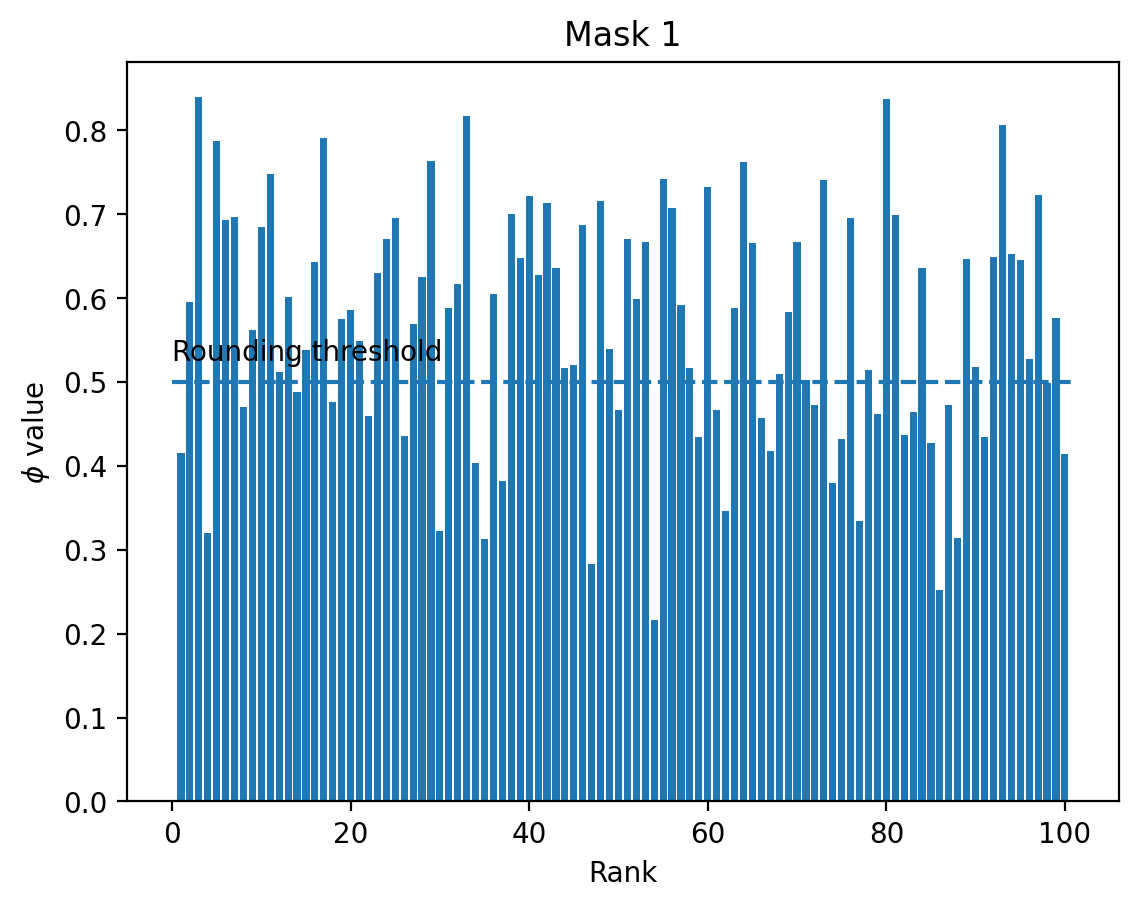

#nz ranks: 67/100

Compression:	4.623
Layer:  Factorized Linear: [512, 784] -> [512, 100]-[100, 784]


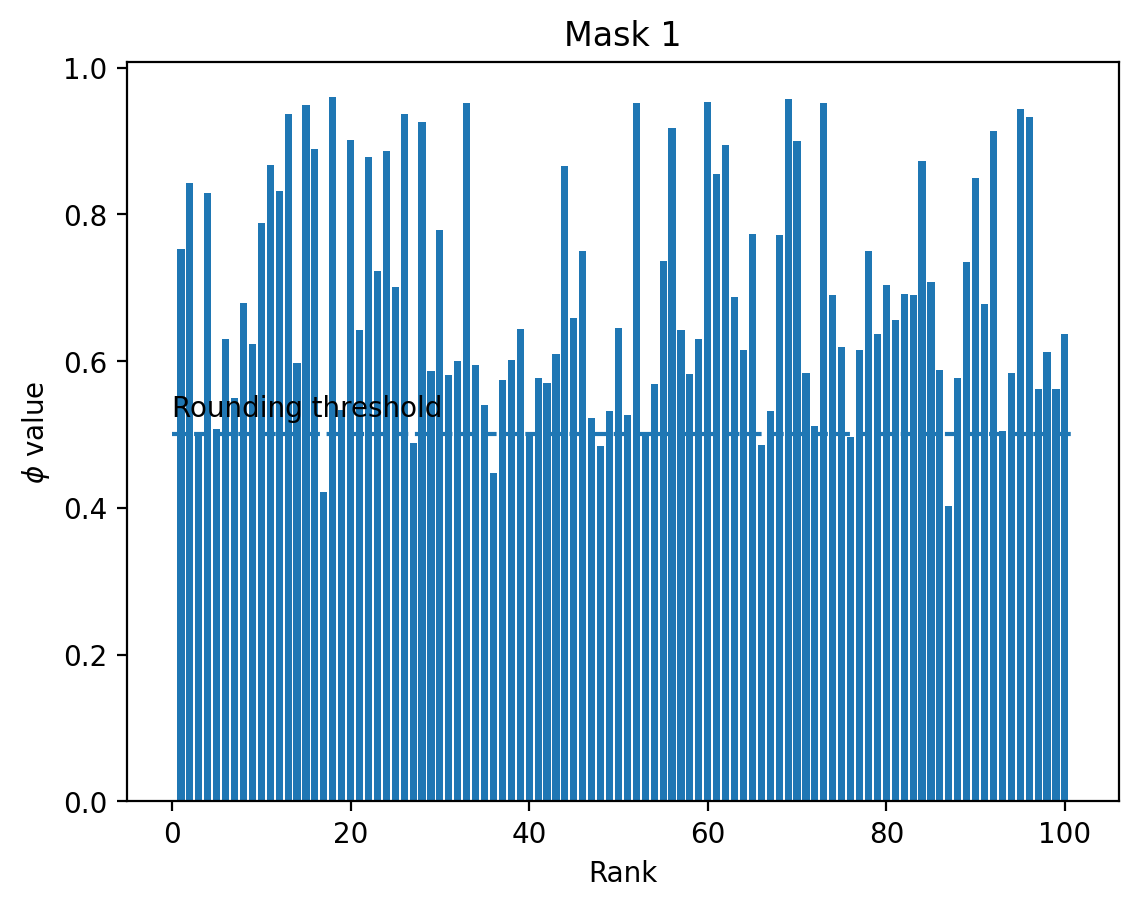

#nz ranks: 93/100

Compression:	3.330
Total compression:	3.819


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [12]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

Next, we will write some code to train the autoencoder on the MNIST dataset.

What should we look at once we've trained an autoencoder? I think that the following things are useful:

1. Look at the latent space. If the latent space is 2-dimensional, then we can transform a batch of inputs $x$ using the encoder and make a scatterplot of the output vectors. Since we also have access to labels for MNIST, we can colour code the outputs to see what they look like.
2. Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

In [13]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            plt.savefig("images/FactorizedAE-Hard-latent")
            break

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

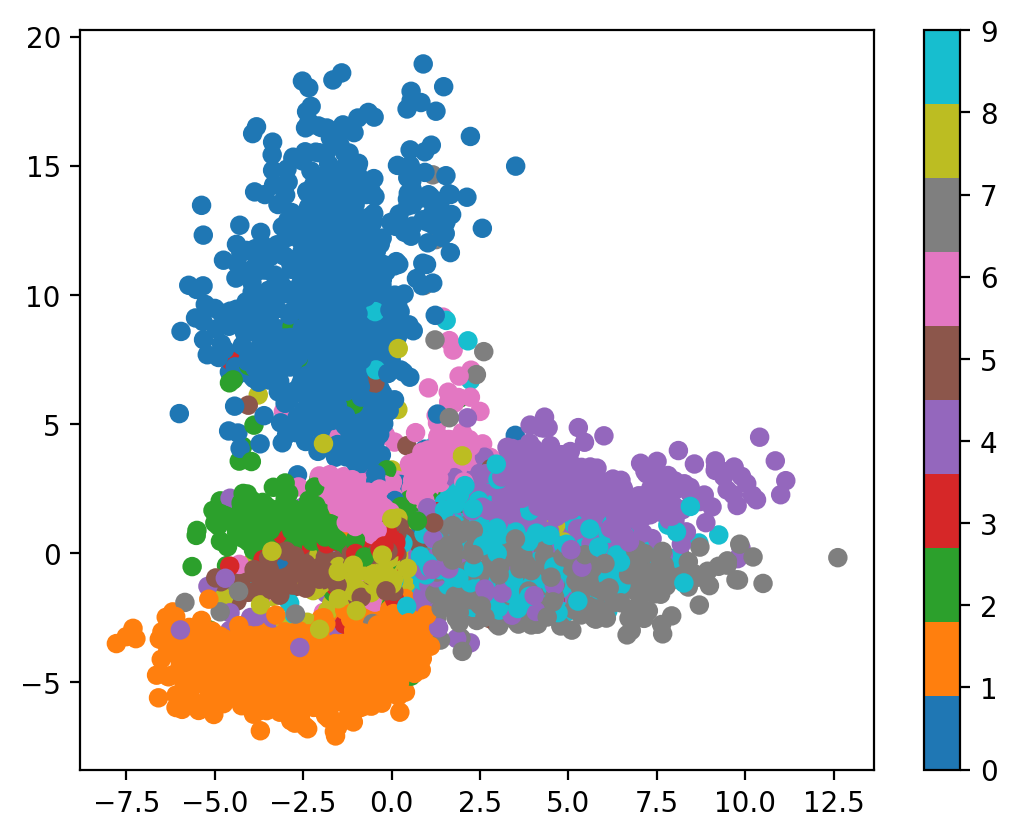

In [14]:
plot_latent(models[0], data)

In [15]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.savefig("images/FactorizedAE-Hard-reconstructed")

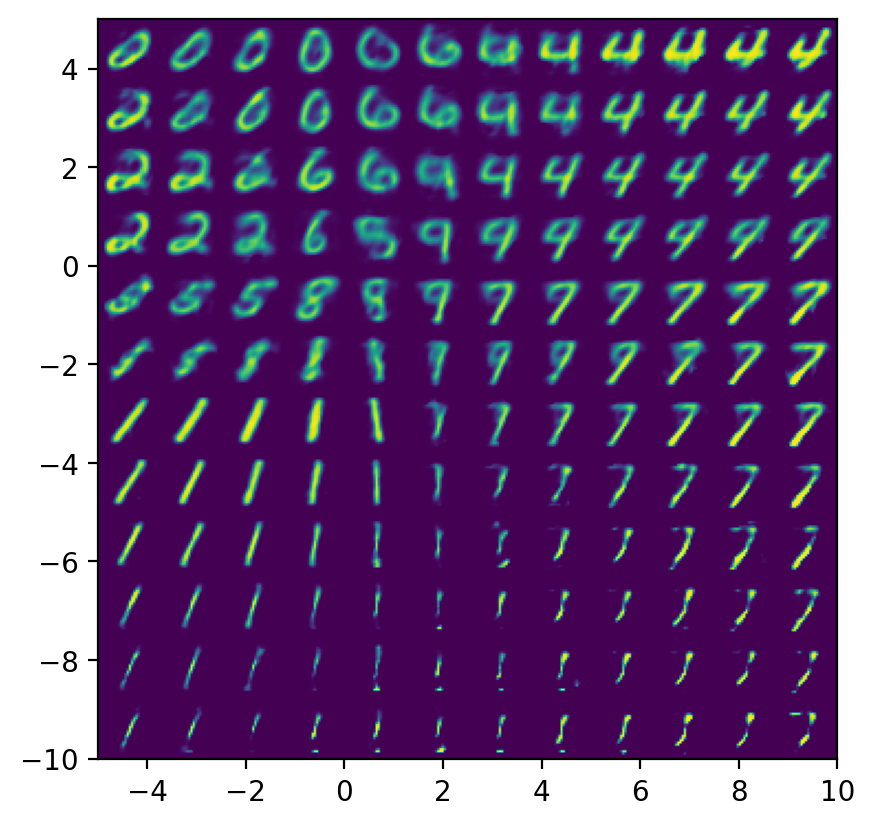

In [16]:
plot_reconstructed(models[0])

## Time

In [17]:
batch = next(iter(data))[0]

In [19]:
%timeit models[0](batch)

615 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
